In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

sns.set()

In this section, we load the RECS (Residential Energy Consumption Survey) dataset and remove columns associated with the "End-use Model" to avoid using derived features from other models.

In [67]:
recs_codebook_df = pd.read_csv('2020_RECS_Code_Book - codebook(1).csv', header=1)
print("Codebook loaded successfully.")

recs_df = pd.read_csv('recs2020_data.csv')
print("Data loaded successfully.")

Codebook loaded successfully.
Data loaded successfully.


In [68]:
recs_codebook_df.head()

Comment Include      Variable Dtype  Type  \
0                                  UID       y         DOEID   num   Num   
1                should we choose one?       y       REGIONC   cat  Char   
2                should we choose one?       n      DIVISION   NaN  Char   
3  These are redundant, let's pick one       n    STATE_FIPS   NaN  Char   
4                                  NaN       y  state_postal   cat  Char   

                              Description and Labels  \
0              Unique identifier for each respondent   
1                                      Census Region   
2  Census Division, Mountain Division is divided ...   
3   State Federal Information Processing System Code   
4                                  State Postal Code   

                                      Response Codes    Section  
0                                      100001-118496      ADMIN  
1                    Midwest\nNortheast\nSouth\nWest  GEOGRAPHY  
2  East North Central\nEast South Central\nMiddle...  GEOGRAPHY  
3                                state_dictionary!A1  GEOGRAPHY  
4                                state_dictionary!A1  GEOGRAPHY

In [69]:
# Filter for only single-family homes (attached and detached)
single_family_homes = recs_df[(recs_df['TYPEHUQ'] == 2) | (recs_df['TYPEHUQ'] == 3)]

# Further filtering to the midwest
single_family_homes = single_family_homes[single_family_homes['REGIONC'] == 'MIDWEST']

# Function to convert floats to integers and preserve NaN
def convert_to_int(x):
    if isinstance(x, float):
        if np.isnan(x):
            return np.nan  # Preserve NaN
        else:
            return int(x)  # Convert float to integer
    return x

# Apply the conversion to all numeric values
single_family_homes = single_family_homes.applymap(convert_to_int)

# Now, select columns where 'Include' is 'y' or 'category'
cols_to_keep = recs_codebook_df[recs_codebook_df['Include'] == 'y']['Variable'].tolist()

# Select columns marked as 'outlier' to handle them separately
cols_to_fix = recs_codebook_df[(recs_codebook_df['Include'] == 'outlier') |
                              (recs_codebook_df['Include'] == 'category')]['Variable'].tolist()

# Create a subset of the dataframe with selected columns
df_y = single_family_homes[cols_to_keep]
df_f = single_family_homes[cols_to_fix]

print(f"Selected {len(cols_to_keep)} features for analysis.")
print(f"Selected {len(cols_to_fix)} features to update.")


Selected 49 features for analysis.
Selected 85 features to update.


In [70]:
# Handle outliers using .loc[] to avoid the SettingWithCopyWarning
df_f.loc[:, ['USEHUMID', 'H2OMAIN']] = df_f.loc[:, ['USEHUMID', 'H2OMAIN']].replace(99, 5)
df_f.loc[:, ['USECFAN', 'USEDEHUM']] = df_f.loc[:, ['USECFAN', 'USEDEHUM']].replace(99, 0)
df_f.loc[:, ['EQUIPM', 'EQUIPAUXTYPE']] = df_f.loc[:, ['EQUIPM', 'EQUIPAUXTYPE']].replace(99, 15)
df_f.loc[:, 'FUELAUX'] = df_f.loc[:, 'FUELAUX'].replace(99, 9)

# Replace values globally in df_f
df_f.replace(-2, 0, inplace=True)

# Now combine the cleaned 'outlier' columns with the main dataframe
subset_df = df_y.join(df_f)

# Checking the shape of the combined dataframe
print(subset_df.shape)

# Checking the number of missing values after combining
missing_values = subset_df.isnull().sum().sort_values(ascending=False)
print(missing_values)

(3095, 134)
MEDICALDEV    28
EVHOMEAMT      1
DOEID          0
NUMWWAC        0
COOLAPT        0
              ..
SQFTEST        0
BACKUP         0
POWEROUT       0
LGTOUTANY      0
EVCHRGTYPE     0
Length: 134, dtype: int64


/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_2135/1463169775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f.replace(-2, 0, inplace=True)


In [71]:
# Calculate the number of non-missing values in each column
number_values = subset_df.count()

# Identify columns with more than 25% missing data
threshold = 0.75 * len(subset_df)
cols_to_drop = [col for col in subset_df.columns if subset_df[col].count() < threshold]

# Drop columns with too many missing values
subset_df = subset_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns due to excessive missing data.")

# Recalculate the number of missing values
missing_percentage = subset_df.isnull().mean() * 100
print(f"Remaining missing data percentage: {missing_percentage.mean():.2f}%")

# Check the number of features with missing data
num_missing_cols = subset_df.columns[subset_df.isnull().any()].tolist()
print(f"There are {len(num_missing_cols)} features with missing data remaining.")


Dropped 0 columns due to excessive missing data.
Remaining missing data percentage: 0.01%
There are 2 features with missing data remaining.


In [72]:
subset_df = subset_df.dropna()
subset_df.head()

DOEID  REGIONC state_postal BA_climate UATYP10  HDD65  CDD65  \
13  100014  MIDWEST           MN  Very-Cold       R  10298    189   
20  100021  MIDWEST           IL       Cold       U   5491   1227   
23  100024  MIDWEST           SD       Cold       R   6728    886   
24  100025  MIDWEST           IL       Cold       R   5328   1051   
26  100027  MIDWEST           MN       Cold       U   7115    881   

    HDD30YR_PUB  CDD30YR_PUB  KOWNRENT  ...  NGPAY  LPGPAY  FOPAY  SMARTMETER  \
13        11113          104         1  ...      0       0      0           1   
20         5680         1075         2  ...      1       0      0           1   
23         6621          972         1  ...      0       0      0           0   
24         5750         1064         1  ...      1       0      0          -4   
26         8086          586         1  ...      1       0      0          -4   

    INTDATAACC  SOLAR  WOODTYPE  OUTLET  EVHOMEAMT  EVCHRGTYPE  
13           0      0         0       0        0.0           0  
20           0      0         0       0        0.0           0  
23           0      0         0       1        0.0           0  
24           0      0         0       0        0.0           0  
26           0      0         0       1        0.0           0  

[5 rows x 134 columns]

In [73]:
numerical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Num']['Variable'].tolist()
categorical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Char']['Variable'].tolist()

numerical_cols = [col for col in numerical_cols if col in subset_df.columns]
categorical_cols = [col for col in categorical_cols if col in subset_df.columns]

In [74]:
subset_df[numerical_cols].head()

DOEID  HDD65  CDD65  HDD30YR_PUB  CDD30YR_PUB  CELLAR  CRAWL  CONCRETE  \
13  100014  10298    189        11113          104       1      0         0   
20  100021   5491   1227         5680         1075       1      0         0   
23  100024   6728    886         6621          972       1      0         0   
24  100025   5328   1051         5750         1064       1      1         0   
26  100027   7115    881         8086          586       1      0         1   

    BASEOTH  BASEFIN  ...  BTUEL  DBT1  DBT99  BTUEL  GWT  WOODTYPE  OUTLET  \
13        0        1  ...  30595    82    -17  30595   38         0       0   
20        0        0  ...   5441    89      5   5441   50         0       0   
23        0        1  ...  33972    93      0  33972   48         0       1   
24        0        0  ...  17414    90      6  17414   52         0       0   
26        0        1  ...  34040    88     -5  34040   43         0       1   

    ELECVEH  EVHOMEAMT  EVCHRGTYPE  
13        0        0.0           0  
20        0        0.0           0  
23        0        0.0           0  
24        0        0.0           0  
26        0        0.0           0  

[5 rows x 130 columns]

In [75]:
# Normalize numerical columns using Min-Max scaling
scaler = MinMaxScaler()
subset_df[numerical_cols] = scaler.fit_transform(subset_df[numerical_cols])

print("Normalization of numerical data completed.")

Normalization of numerical data completed.


In [76]:
subset_df = pd.get_dummies(subset_df, columns=categorical_cols)

In [77]:
subset_df.head()

DOEID     HDD65     CDD65  HDD30YR_PUB  CDD30YR_PUB  KOWNRENT  \
13  0.000000  1.000000  0.035674     1.000000     0.026137       0.0   
20  0.000379  0.335774  0.623443     0.270150     0.533717       0.5   
23  0.000541  0.506702  0.430351     0.396561     0.479875       0.0   
24  0.000595  0.313251  0.523783     0.279554     0.527967       0.0   
26  0.000703  0.560177  0.427520     0.593364     0.278097       0.0   

    YEARMADERANGE  BEDROOMS  NCOMBATH  NHAFBATH  ...  state_postal_NE  \
13          0.125  0.666667      0.25       0.0  ...            False   
20          0.250  0.333333      0.25       0.5  ...            False   
23          0.625  0.500000      0.75       0.0  ...            False   
24          0.000  0.333333      0.25       0.0  ...            False   
26          0.750  0.833333      0.75       0.5  ...            False   

    state_postal_OH  state_postal_SD  state_postal_WI  BA_climate_Cold  \
13            False            False            False            False   
20            False            False            False             True   
23            False             True            False             True   
24            False            False            False             True   
26            False            False            False             True   

    BA_climate_Mixed-Humid  BA_climate_Very-Cold  UATYP10_C  UATYP10_R  \
13                   False                  True      False       True   
20                   False                 False      False      False   
23                   False                 False      False       True   
24                   False                 False      False       True   
26                   False                 False      False      False   

    UATYP10_U  
13      False  
20       True  
23      False  
24      False  
26       True  

[5 rows x 149 columns]

In [78]:
# Perform PCA to capture 90% of the variance
pca = PCA(n_components=0.90, random_state=42)
pca_result = pca.fit_transform(subset_df)

print(f"PCA reduced the dataset to {pca_result.shape[1]} principal components.")


PCA reduced the dataset to 56 principal components.


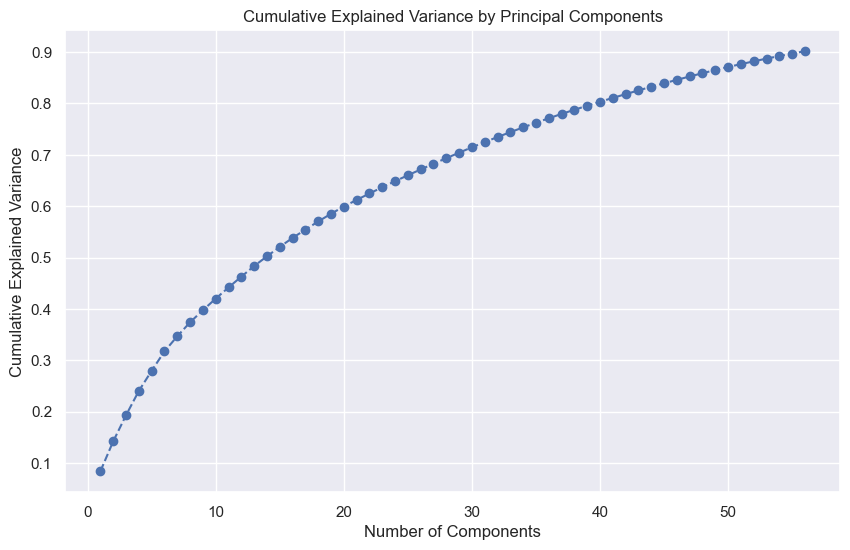

Number of components explaining at least 90% variance: 56


In [79]:
# Plot cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the number of components that explain at least 90% of the variance
components_90_variance = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components explaining at least 90% variance: {components_90_variance}")

pca_90 = PCA(n_components=components_90_variance)
pca_90_result = pca_90.fit_transform(subset_df)

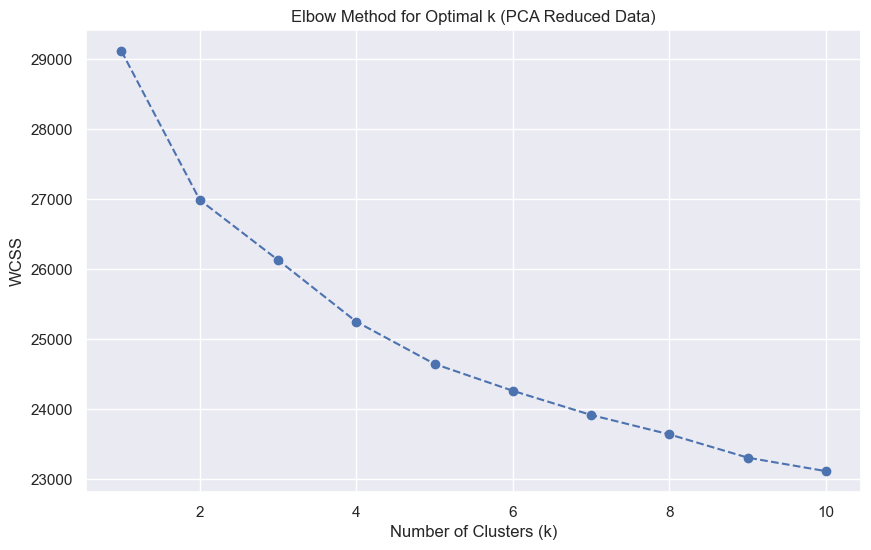

In [80]:
# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

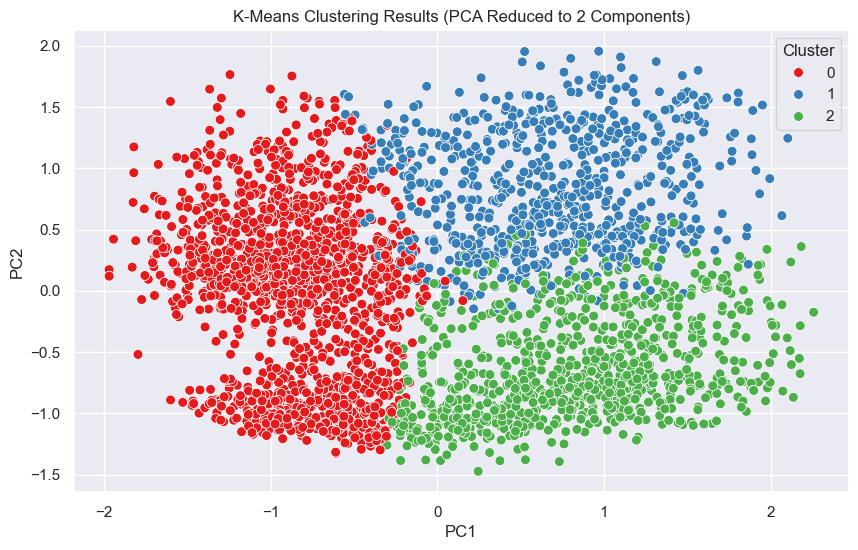

In [81]:
# Perform K-means clustering with the chosen k
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Reduce to 2 components for visualization
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components)')
plt.show()

/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_2135/3374192844.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subset_df['cluster'] = kmeans.predict(pca_result)


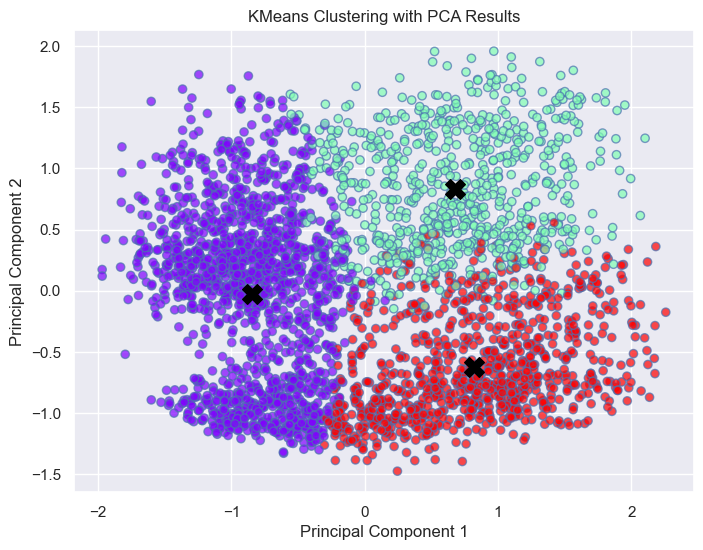

In [82]:
subset_df['cluster'] = kmeans.predict(pca_result)

# Plot the PCA result and KMeans clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

# Plot the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X')

# Add titles and labels
plt.title('KMeans Clustering with PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show plot
plt.show()

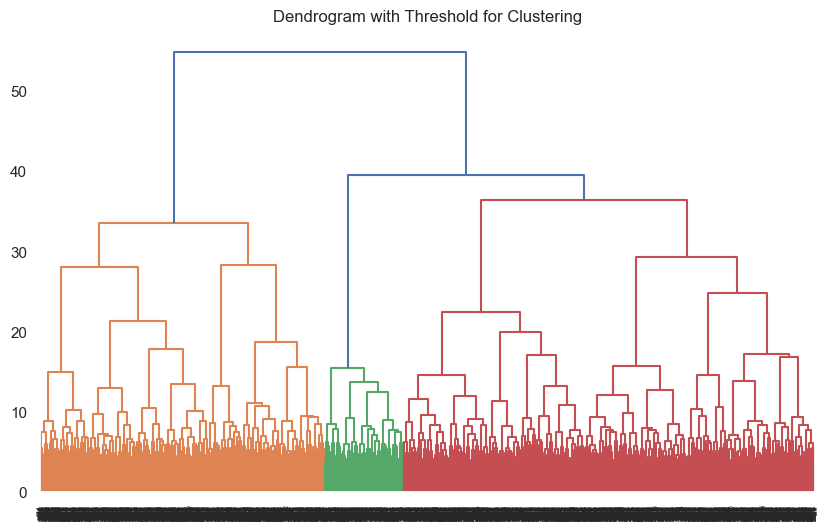

In [83]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot the Dendrogram with a threshold
plt.figure(figsize=(10, 6))
plt.title("Dendrogram with Threshold for Clustering")
dend = shc.dendrogram(shc.linkage(pca_90_result, method='ward'))
plt.show()

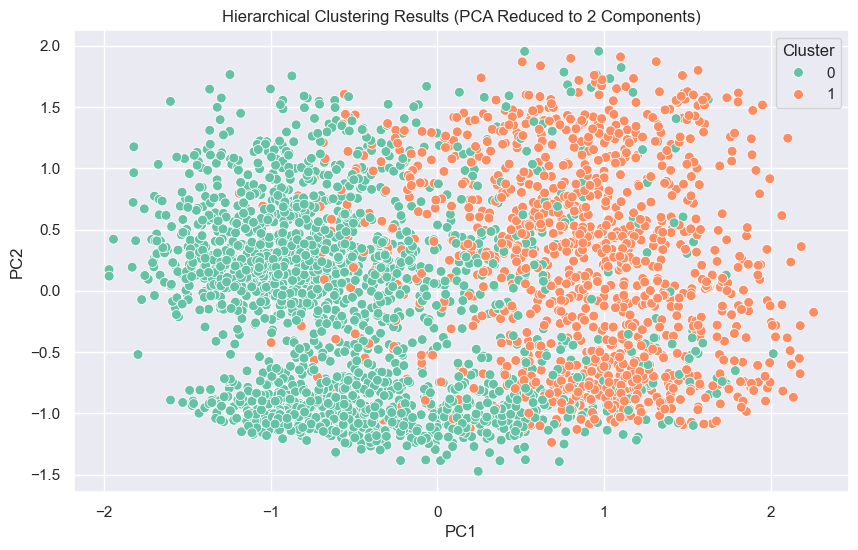

In [84]:
# Perform Hierarchical Clustering with chosen clusters
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  

# Visualize the clusters using the first two PCA components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=50)
plt.title('Hierarchical Clustering Results (PCA Reduced to 2 Components)')
plt.show()

We begin by generating summary statistics for each cluster. This will give us an understanding of the average values, medians, and ranges of key features for each cluster.

In [85]:
# Generate summary statistics for each cluster (numerical columns only)
def get_cluster_summary(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select only numerical columns
    numeric_data = data.select_dtypes(include=[np.number])
    summary = numeric_data.groupby('Cluster').agg(['mean', 'median', 'min', 'max'])
    return summary

# Apply to K-means clusters
kmeans_summary = get_cluster_summary(subset_df.copy(), kmeans_labels)
print(kmeans_summary)

            DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.481805  0.464858  0.000541  0.999188  0.453243  0.434296  0.093271   
1        0.496096  0.503787  0.000000  0.997132  0.437480  0.404104  0.000000   
2        0.515128  0.509388  0.000379  1.000000  0.408335  0.384690  0.094514   

                      CDD65            ... EVHOMEAMT           EVCHRGTYPE  \
              max      mean    median  ...       min       max       mean   
Cluster                                ...                                  
0        0.988946  0.451875  0.427520  ...       0.0  1.000000   0.009669   
1        1.000000  0.442992  0.436014  ...       0.0  1.000000   0.005556   
2        0.975128  0.467251  0.451019  ...       0.0  0.333333   0.001670   

                           cluster                

In [86]:
# Frequency analysis for categorical columns
def get_categorical_frequency(data, cluster_labels):
    # Add the 'Cluster' column to the full dataframe
    data['Cluster'] = cluster_labels
    
    # Include 'Cluster' in the dataset explicitly
    categorical_data = data.select_dtypes(include=['object', 'category', 'bool']).copy()
    
    # Add back the 'Cluster' column since it might get excluded from filtering
    categorical_data['Cluster'] = data['Cluster']
    
    # Calculate the frequency
    frequency = categorical_data.groupby('Cluster').apply(lambda x: x.apply(pd.Series.value_counts))
    
    return frequency

# Apply to K-means clusters
# kmeans_categorical_frequency = get_categorical_frequency(subset_df.copy(), kmeans_labels)
# print(kmeans_categorical_frequency)

# Apply to hierarchical clusters
hierarchical_categorical_frequency = get_categorical_frequency(subset_df.copy(), hierarchical_labels)
print('\n\n\n', hierarchical_categorical_frequency)





                REGIONC_MIDWEST  state_postal_IA  state_postal_IL  \
Cluster                                                            
0       False              NaN             1768             1684   
        True            1938.0              170              254   
1       False              NaN             1049              999   
        True            1128.0               79              129   

               state_postal_IN  state_postal_KS  state_postal_MI  \
Cluster                                                            
0       False             1807             1829             1759   
        True               131              109              179   
1       False              913             1068              991   
        True               215               60              137   

               state_postal_MN  state_postal_MO  state_postal_ND  \
Cluster                                                            
0       False             1751            

In [87]:
from sklearn.ensemble import RandomForestClassifier
importances = []

# Fit a RandomForest to the clustered data to understand feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(subset_df, kmeans_labels)

# Get feature importance
importances = rf.feature_importances_

# Match importance to feature names
feature_importance_df = pd.DataFrame({'Feature': subset_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top Features Driving Cluster Separation:\n", feature_importance_df.head(10))


Top Features Driving Cluster Separation:
           Feature  Importance
149       cluster    0.225648
90       BASECOOL    0.096249
72       EQUIPAUX    0.078200
50        BASEFIN    0.064444
73        FUELAUX    0.062838
78       BASEHEAT    0.056885
74    USEEQUIPAUX    0.052975
71   EQUIPAUXTYPE    0.048176
39       TOTCSQFT    0.033675
55   SIZEOFGARAGE    0.023020


In [88]:
from scipy.stats import zscore

# Calculate Z-scores for each cluster for numerical columns
def cluster_profiling(data, cluster_labels):
    data['Cluster'] = cluster_labels
    numeric_data = data.select_dtypes(include=[np.number])

    # Group by cluster and calculate z-scores to identify the most distinct features
    z_scores = numeric_data.groupby('Cluster').apply(lambda x: zscore(x, nan_policy='omit'))

    # Ensure 'Cluster' is not both in the index and columns
    z_scores.reset_index(drop=True, inplace=True)

    # Calculate the means and Z-scores of features across clusters
    cluster_means = numeric_data.groupby('Cluster').mean()
    
    # Identify the most distinctive features for each cluster
    distinctive_features = z_scores.abs().groupby(data['Cluster']).mean()

    # Sort by the most distinctive feature by mean Z-score for each cluster
    distinctive_features_sorted = distinctive_features.mean(axis=1).sort_values(ascending=False)
    
    return cluster_means, distinctive_features_sorted

# Apply to K-means clusters
kmeans_means, kmeans_distinctive_features = cluster_profiling(subset_df.copy(), kmeans_labels)

print("K-Means Cluster Means:\n", kmeans_means)
print("\nMost Distinctive Features in Each K-Means Cluster:\n", kmeans_distinctive_features)


K-Means Cluster Means:
             DOEID     HDD65     CDD65  HDD30YR_PUB  CDD30YR_PUB  KOWNRENT  \
Cluster                                                                     
0        0.481805  0.453243  0.451875     0.407751     0.407078  0.021064   
1        0.496096  0.437480  0.442992     0.393774     0.401527  0.088889   
2        0.515128  0.408335  0.467251     0.368368     0.423539  0.104120   

         YEARMADERANGE  BEDROOMS  NCOMBATH  NHAFBATH  ...    LPGPAY     FOPAY  \
Cluster                                               ...                       
0             0.486619  0.588283  0.555594  0.291782  ...  0.049724  0.002532   
1             0.291319  0.497222  0.396181  0.154167  ...  0.106944  0.011574   
2             0.313753  0.461581  0.366648  0.172049  ...  0.049555  0.003712   

         SMARTMETER  INTDATAACC     SOLAR  WOODTYPE    OUTLET  EVHOMEAMT  \
Cluster                                                                    
0          0.564088    0.095304 

In [89]:
# Create a contingency table for each categorical variable
def contingency_tables(data, cluster_labels):
    data['Cluster'] = cluster_labels
    categorical_data = data.select_dtypes(include=['object', 'category', 'bool'])
    
    tables = {}
    for col in categorical_data.columns:
        table = pd.crosstab(data[col], data['Cluster'], normalize='columns')  # Proportions within clusters
        tables[col] = table
    
    return tables

# Get contingency tables for K-means clusters
contingency_tables_kmeans = contingency_tables(subset_df.copy(), kmeans_labels)

contingency_tables_kmeans

{'REGIONC_MIDWEST': Cluster            0    1    2
 REGIONC_MIDWEST               
 True             1.0  1.0  1.0,
 'state_postal_IA': Cluster                 0         1         2
 state_postal_IA                              
 False            0.914365  0.926389  0.919822
 True             0.085635  0.073611  0.080178,
 'state_postal_IL': Cluster                 0         1         2
 state_postal_IL                              
 False            0.883287  0.894444  0.846325
 True             0.116713  0.105556  0.153675,
 'state_postal_IN': Cluster                 0         1         2
 state_postal_IN                              
 False            0.938536  0.838889  0.842984
 True             0.061464  0.161111  0.157016,
 'state_postal_KS': Cluster                 0         1         2
 state_postal_KS                              
 False            0.940608  0.956944  0.942094
 True             0.059392  0.043056  0.057906,
 'state_postal_MI': Cluster                 0       

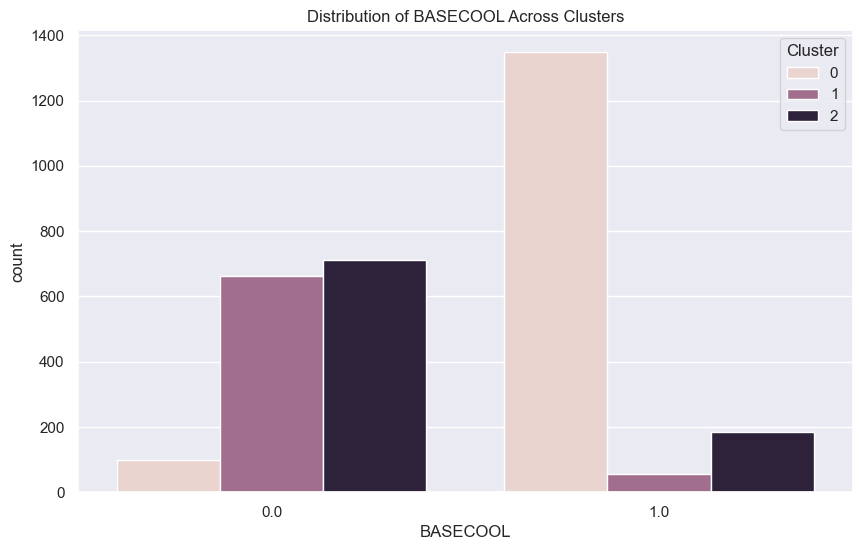

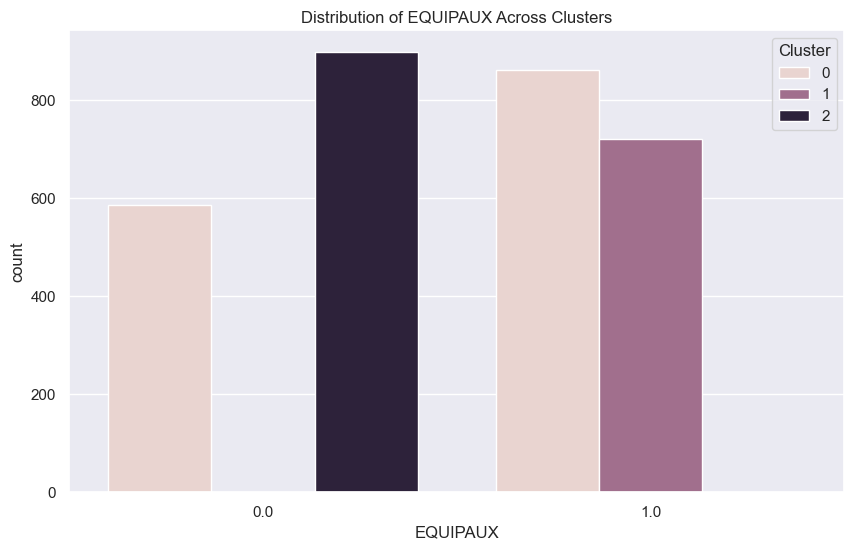

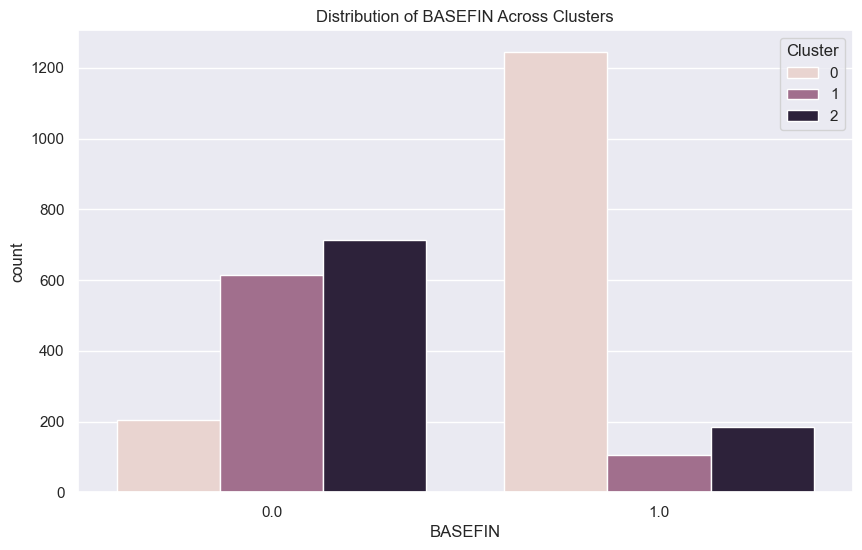

In [90]:
# Visualize the distribution of categorical variables across clusters
def plot_categorical_distributions(data, cluster_labels, categorical_cols):
    data['Cluster'] = cluster_labels
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Cluster', data=data)
        plt.title(f'Distribution of {col} Across Clusters')
        plt.show()

# List of categorical columns to plot
categorical_cols = ['BASECOOL', 'EQUIPAUX', 'BASEFIN']

# Plot distributions for K-means clusters
plot_categorical_distributions(subset_df.copy(), kmeans_labels, categorical_cols)

In [91]:
def get_modes_per_cluster_onehot(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select all binary columns (assuming one-hot encoding produces binary columns)
    binary_data = data.select_dtypes(include=[np.number])
    modes = binary_data.groupby('Cluster').agg(lambda x: x.mode()[0])
    return modes

# Get the mode for K-means clusters in the one-hot encoded data
modes_kmeans = get_modes_per_cluster_onehot(subset_df.copy(), kmeans_labels)
print("Mode of One-Hot Encoded Variables per K-Means Cluster:\n", modes_kmeans)

Mode of One-Hot Encoded Variables per K-Means Cluster:
             DOEID     HDD65     CDD65  HDD30YR_PUB  CDD30YR_PUB  KOWNRENT  \
Cluster                                                                     
0        0.000541  0.404035  0.221404     0.156771     0.287507       0.0   
1        0.000000  0.259085  0.386750     0.455400     0.413487       0.0   
2        0.000379  0.260329  0.432050     0.305078     0.363826       0.0   

         YEARMADERANGE  BEDROOMS  NCOMBATH  NHAFBATH  ...  LPGPAY  FOPAY  \
Cluster                                               ...                  
0                 0.75       0.5      0.50       0.0  ...     0.0    0.0   
1                 0.00       0.5      0.25       0.0  ...     0.0    0.0   
2                 0.00       0.5      0.25       0.0  ...     0.0    0.0   

         SMARTMETER  INTDATAACC  SOLAR  WOODTYPE  OUTLET  EVHOMEAMT  \
Cluster                                                               
0               0.0         0.0    

In [92]:
# Apply to hierarchical clusters
hierarchical_summary = get_cluster_summary(subset_df.copy(), hierarchical_labels)
print(hierarchical_summary)

            DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.487016  0.472974  0.000000  0.999188  0.452680  0.430082  0.066326   
1        0.508503  0.511200  0.000541  1.000000  0.408398  0.384137  0.000000   

                      CDD65            ... EVHOMEAMT      EVCHRGTYPE         \
              max      mean    median  ...       min  max       mean median   
Cluster                                ...                                    
0        1.000000  0.450054  0.430351  ...       0.0  1.0   0.007998    0.0   
1        0.949841  0.461574  0.452435  ...       0.0  1.0   0.003546    0.0   

                    cluster                 
         min  max      mean median min max  
Cluster                                     
0        0.0  1.0  0.477812    0.0   0   2  
1        0.0  1.0 

In [93]:
kmeans_means, kmeans_distinctive_features = cluster_profiling(subset_df.copy(), kmeans_labels)
print("Most Distinctive Features in Each K-Means Cluster:\n", kmeans_distinctive_features)


Most Distinctive Features in Each K-Means Cluster:
 Cluster
1.0    0.646505
2.0    0.640294
0.0    0.636132
dtype: float64


In [94]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(pca_90_result, kmeans_labels)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.06002986314411512


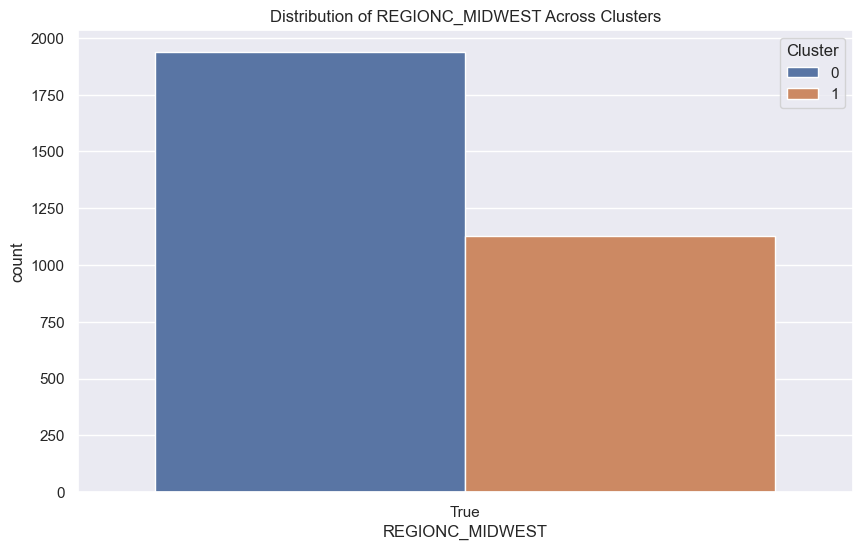

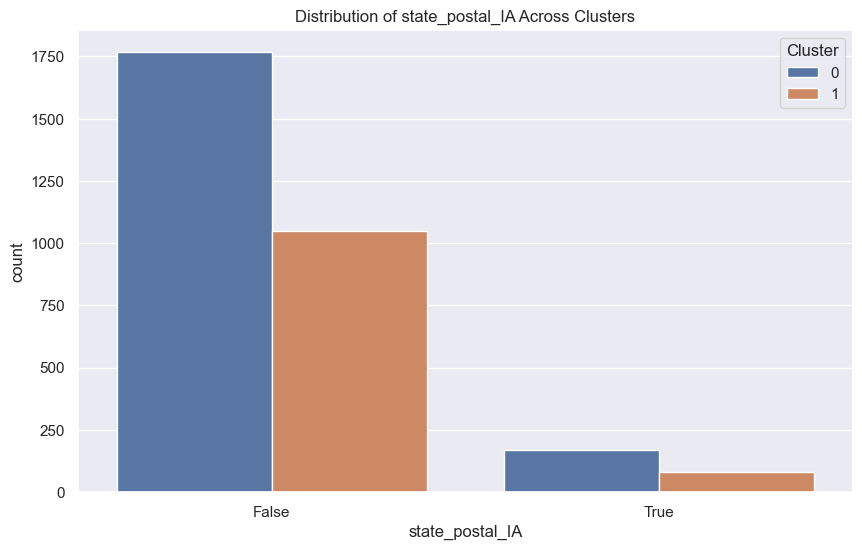

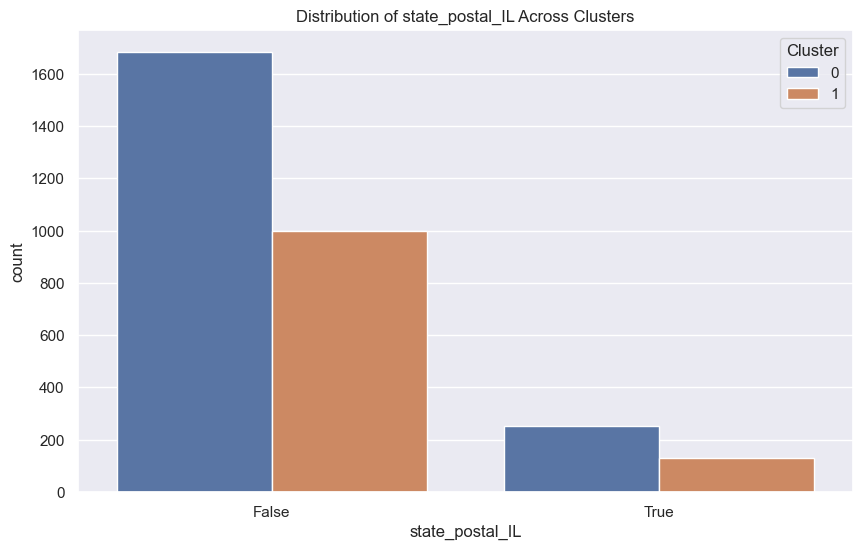

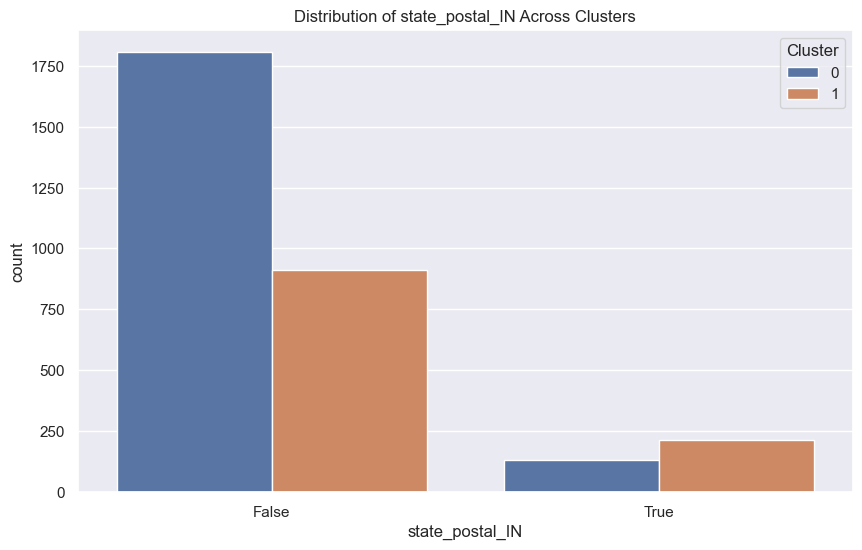

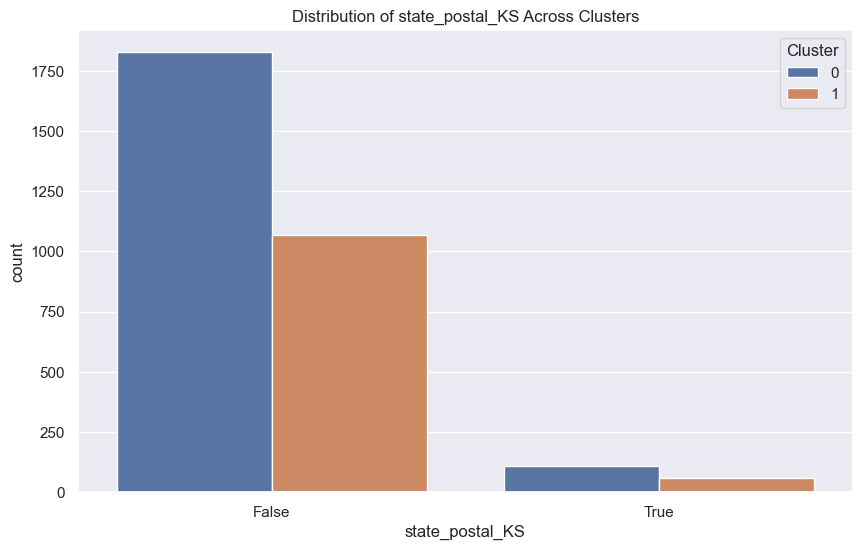

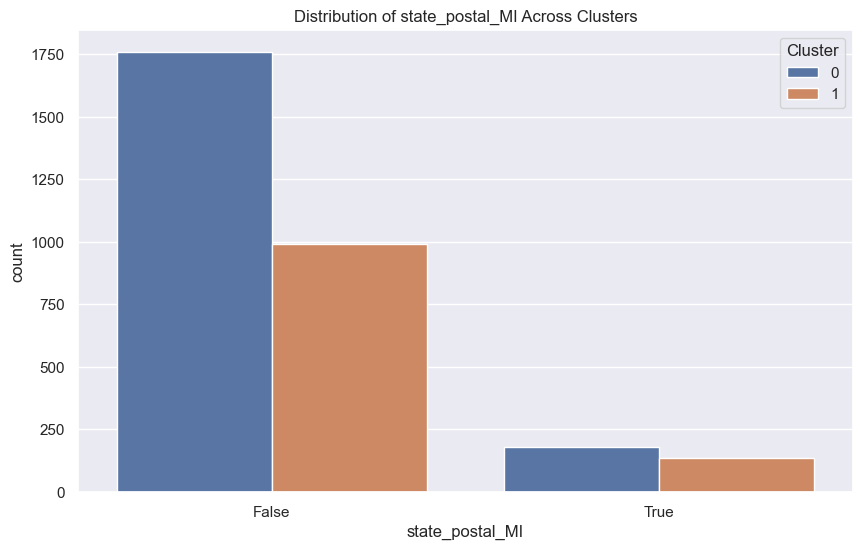

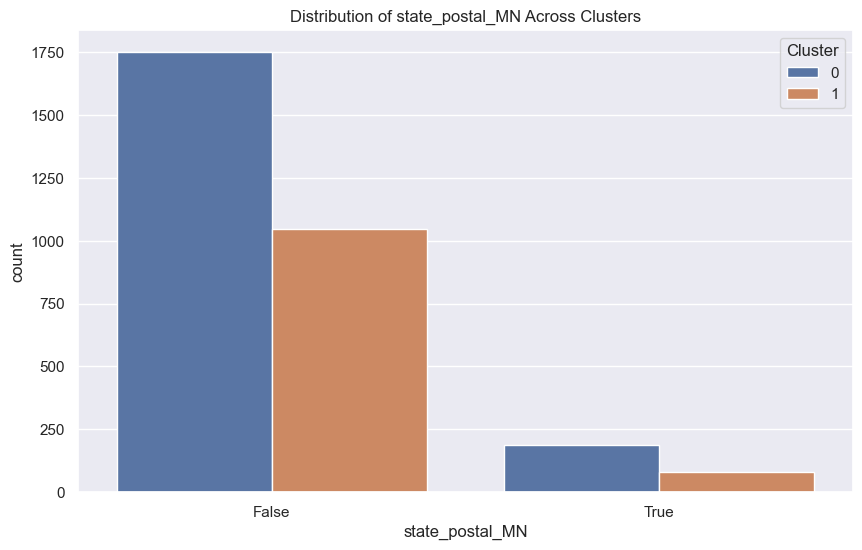

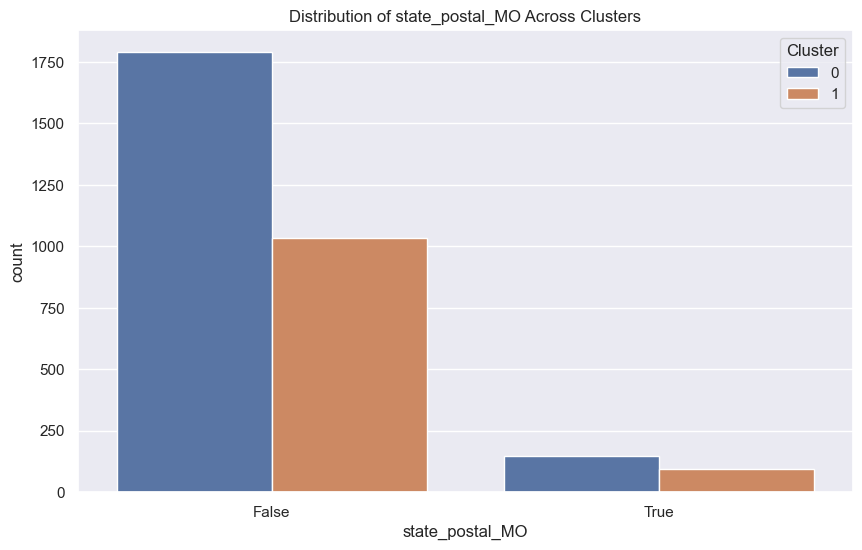

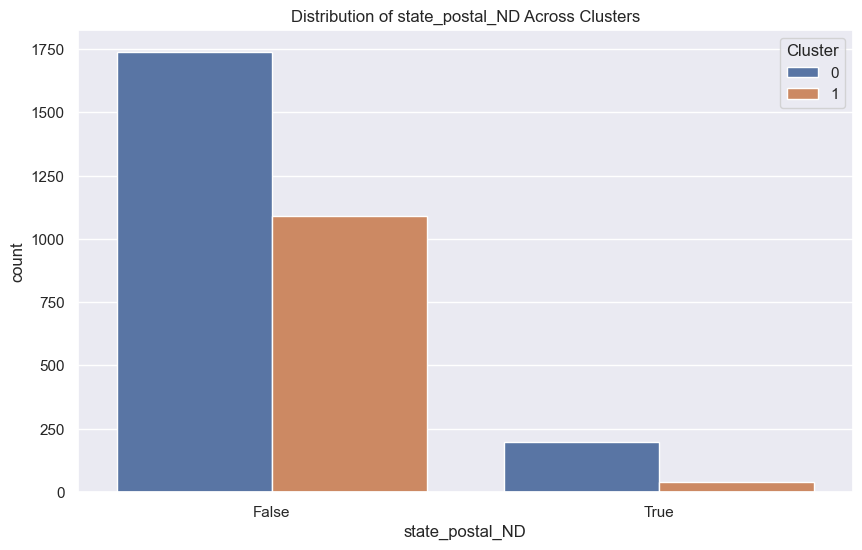

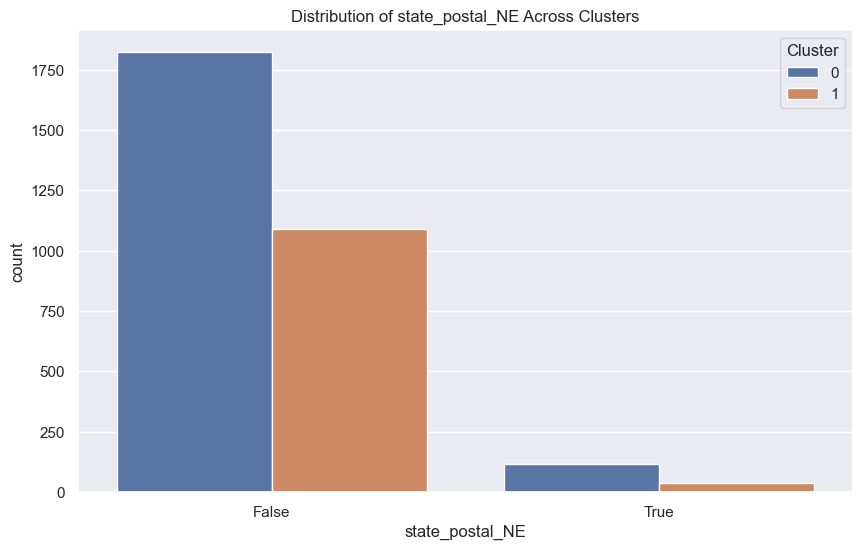

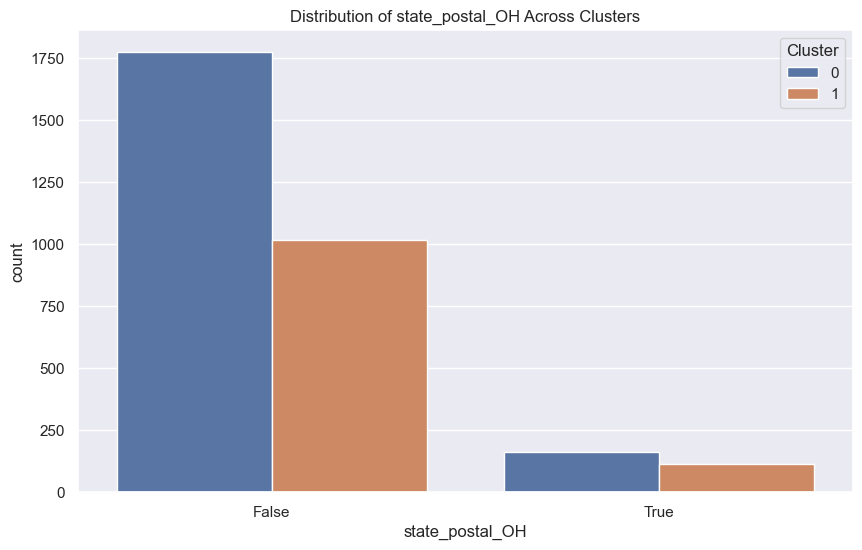

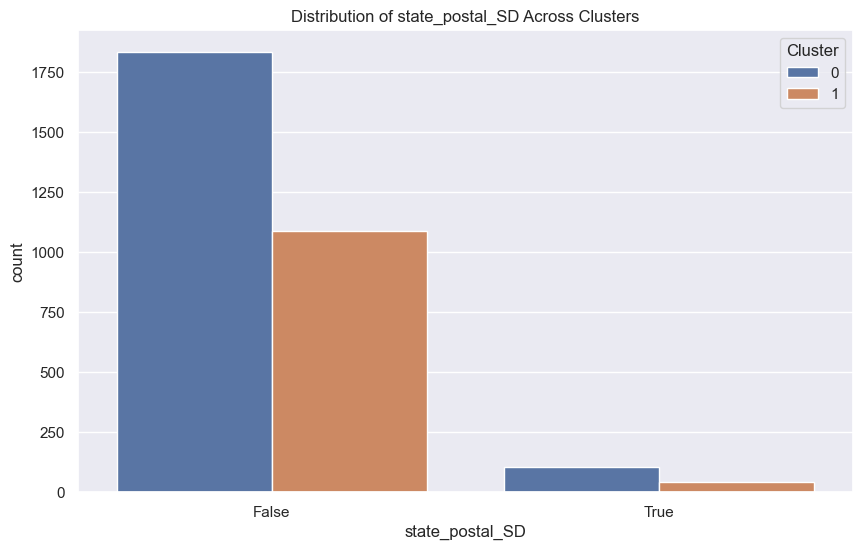

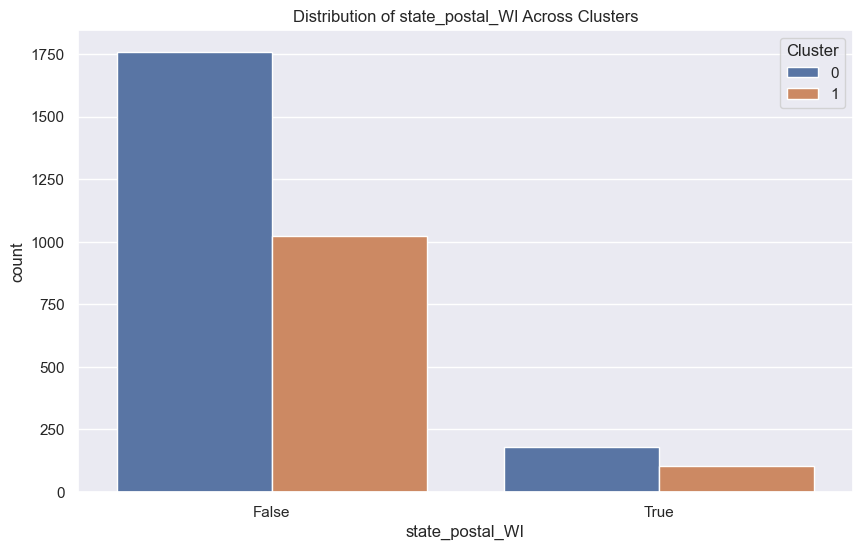

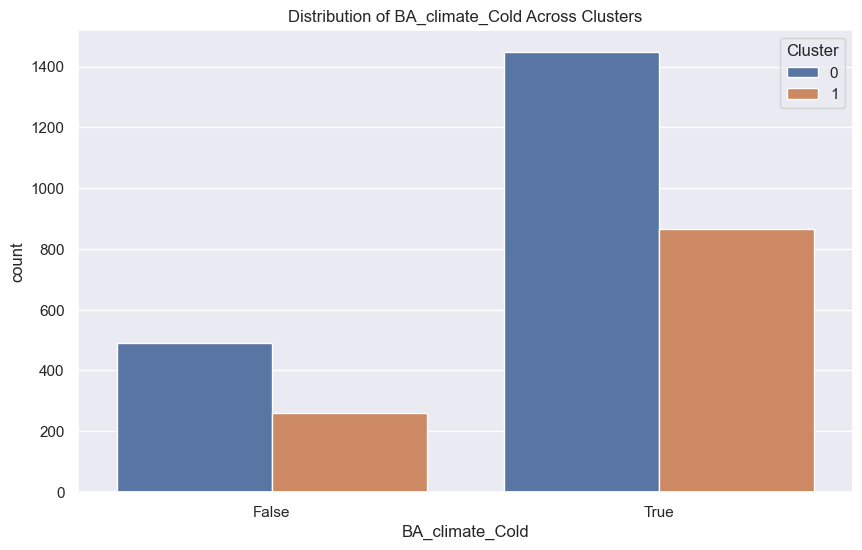

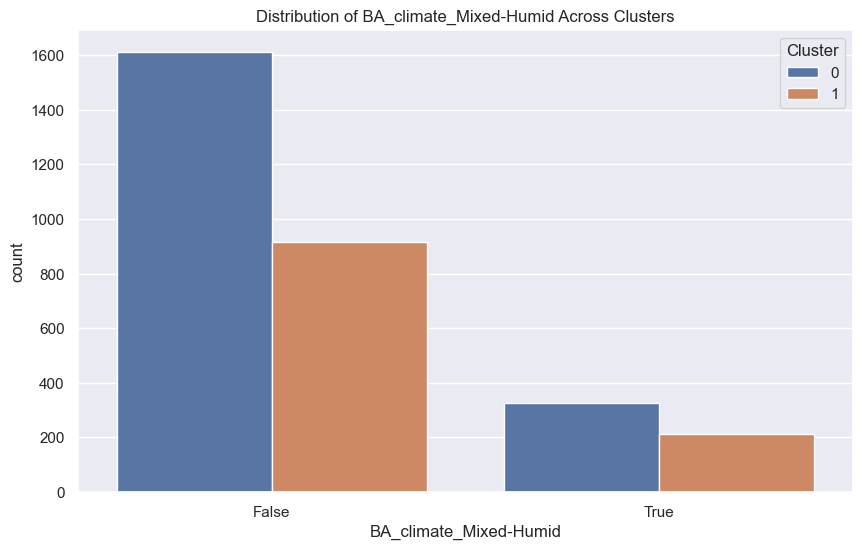

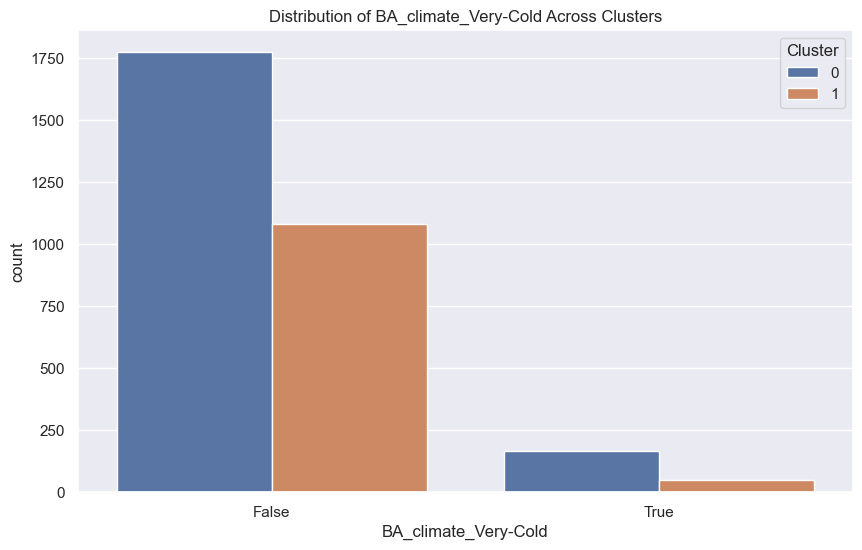

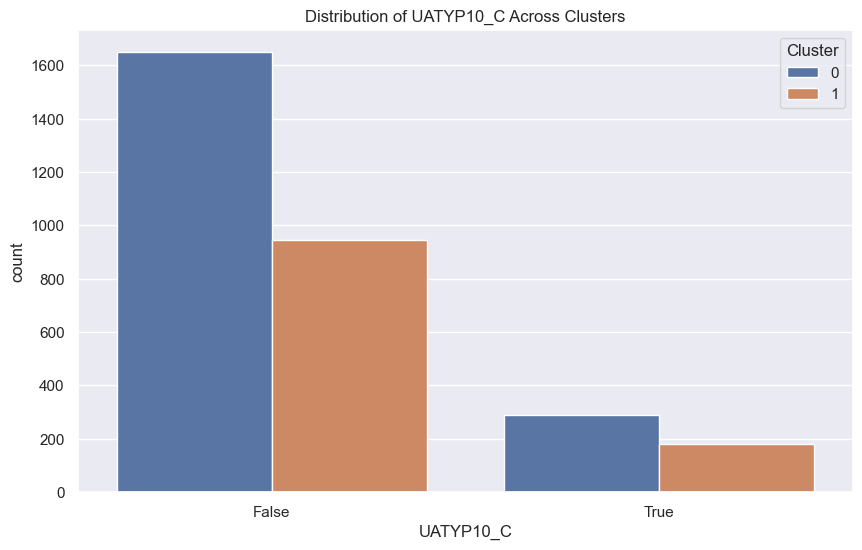

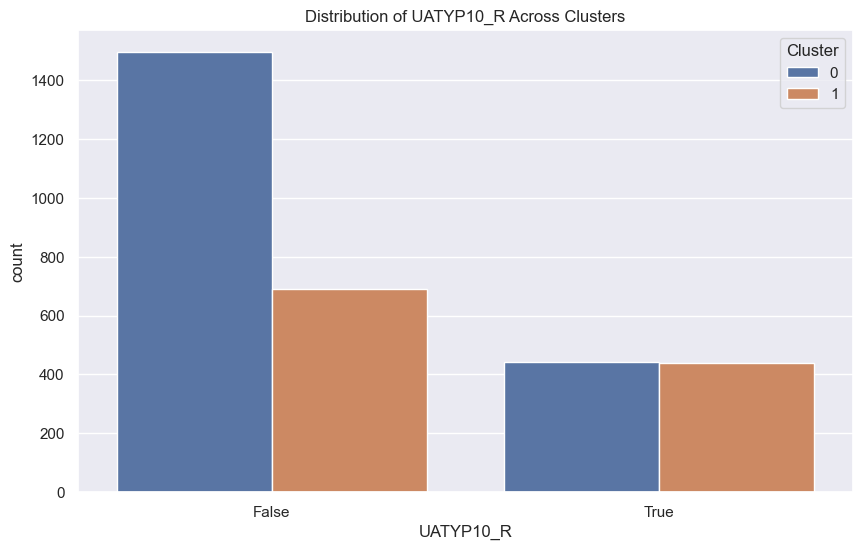

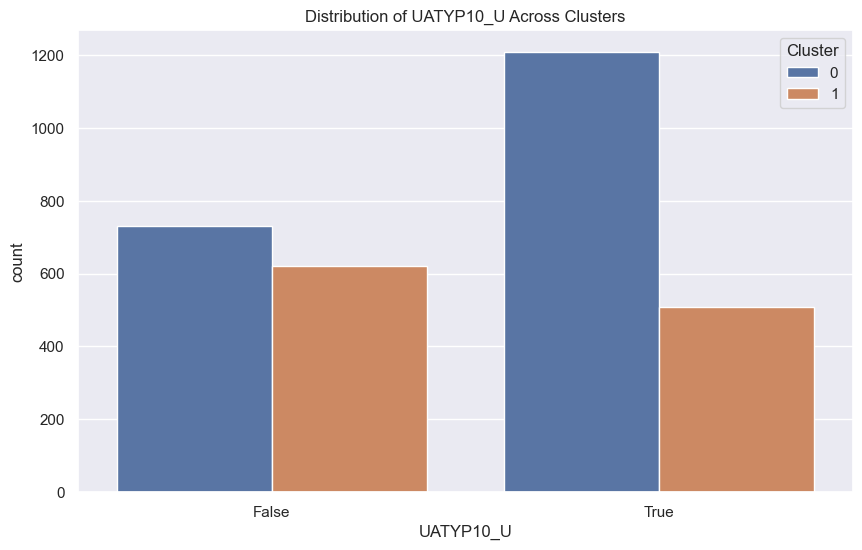

In [95]:
# Function to plot categorical distributions
def plot_categorical_distributions(data, cluster_labels, categorical_cols):
    data['Cluster'] = cluster_labels  # Add cluster labels to the data
    
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Cluster', data=data)  # Plot categorical counts across clusters
        plt.title(f'Distribution of {col} Across Clusters')
        plt.show()

categorical_cols = subset_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Plot distributions for hierarchical clusters
plot_categorical_distributions(subset_df.copy(), hierarchical_labels, categorical_cols)


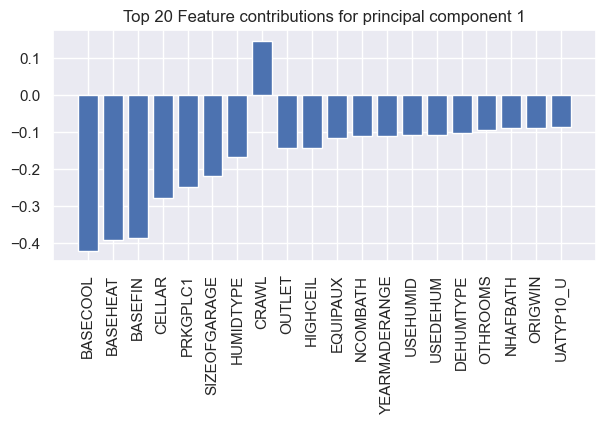

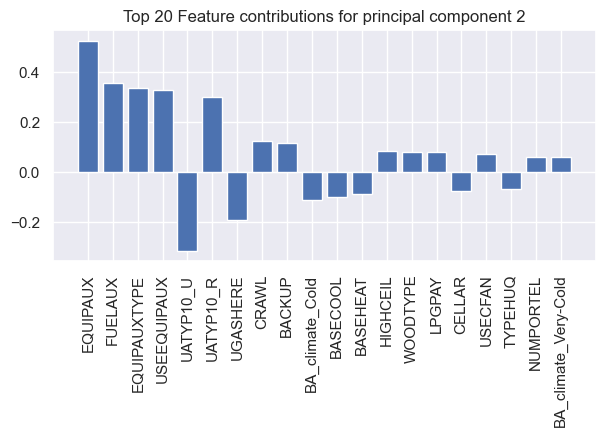

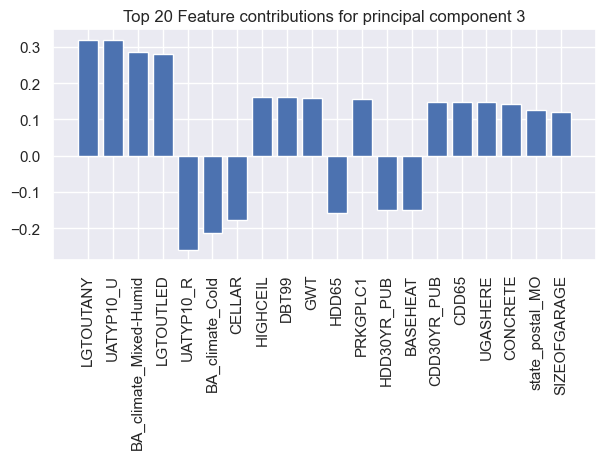

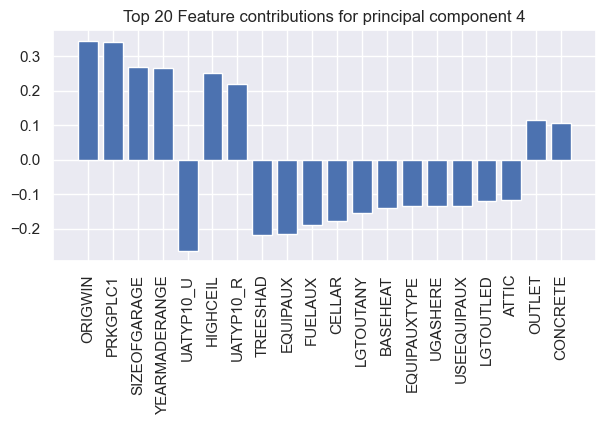

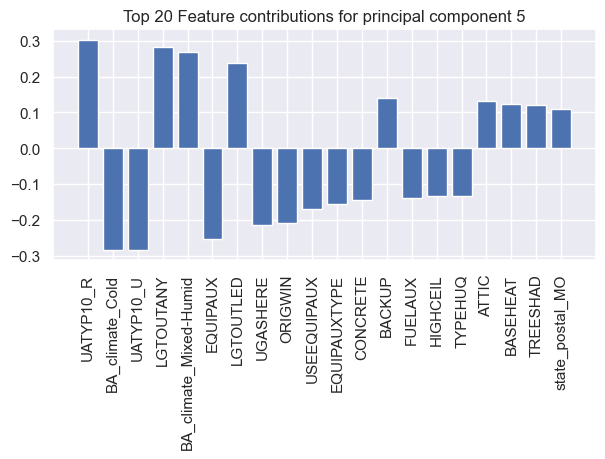

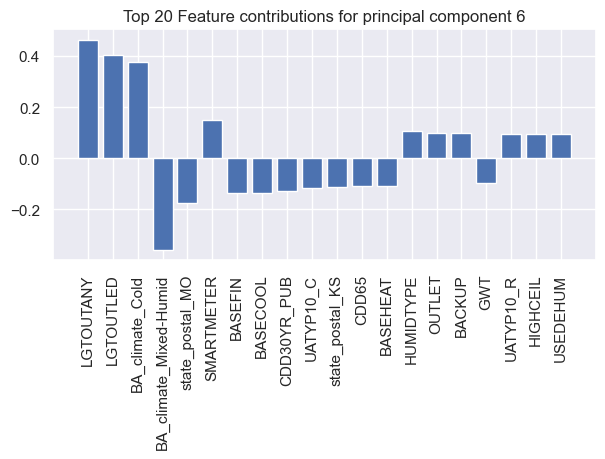

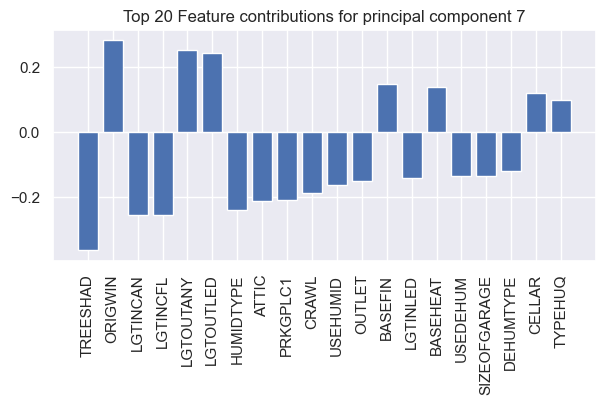

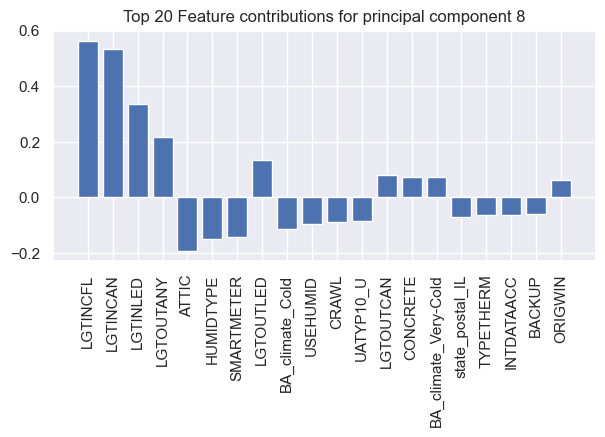

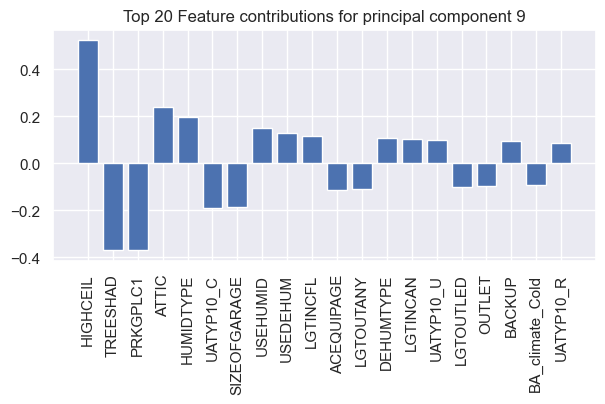

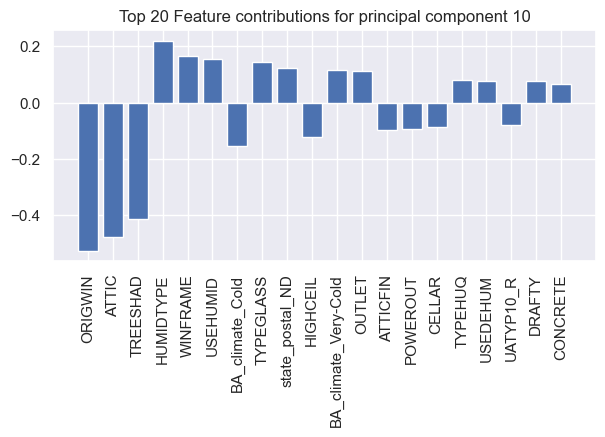

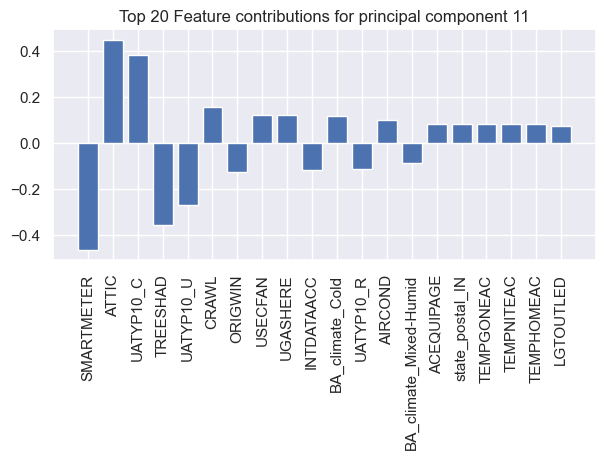

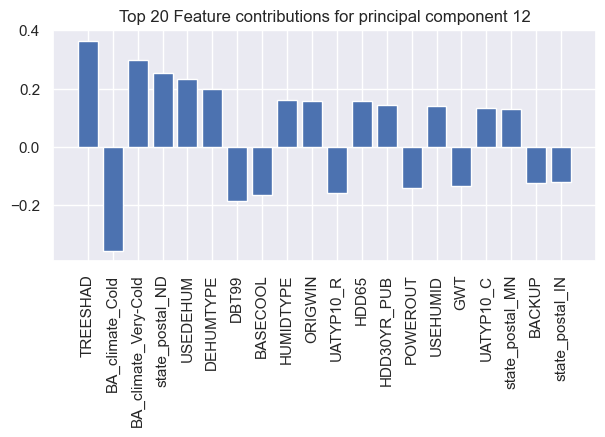

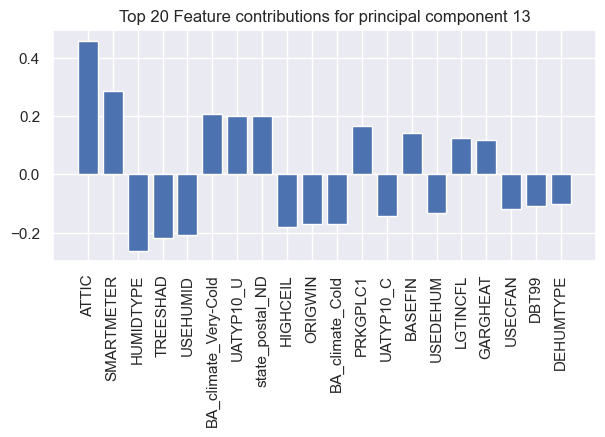

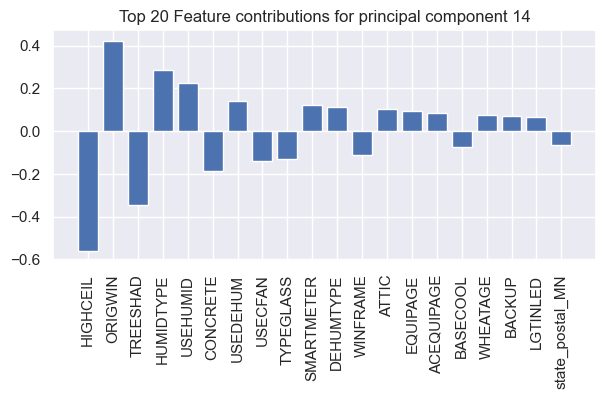

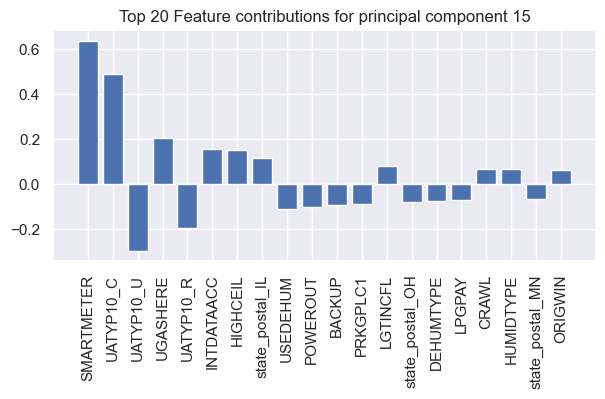

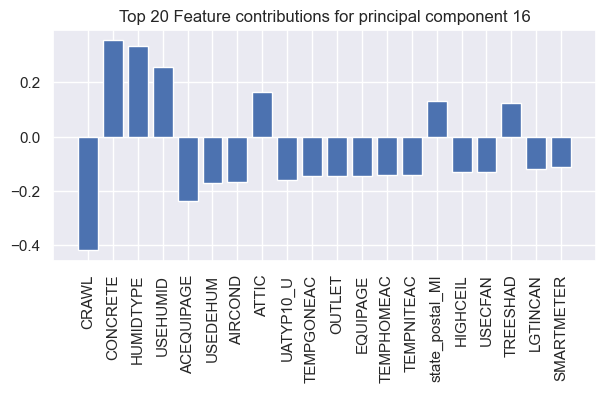

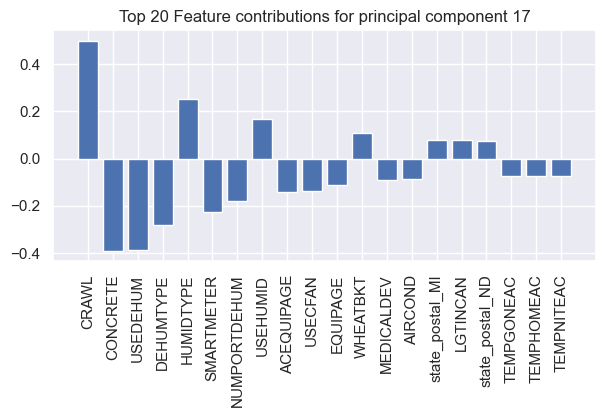

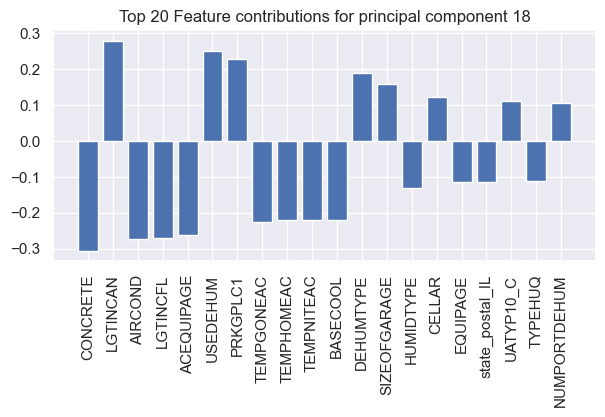

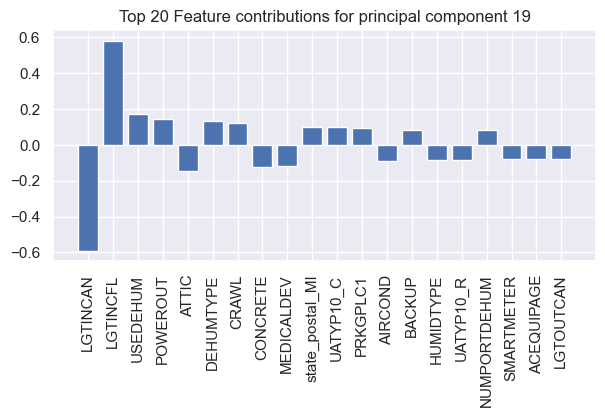

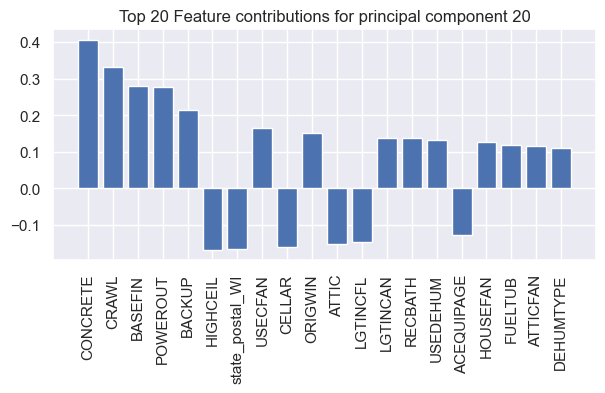

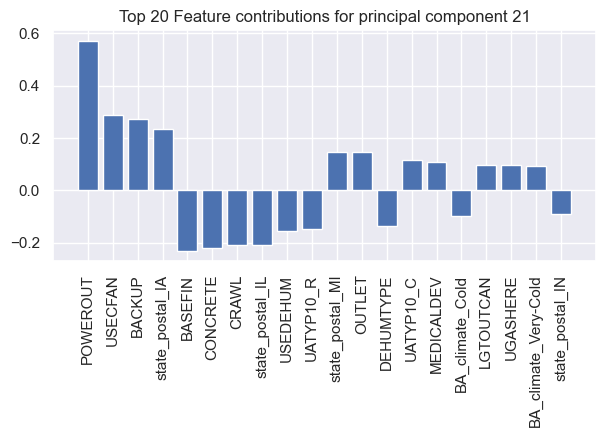

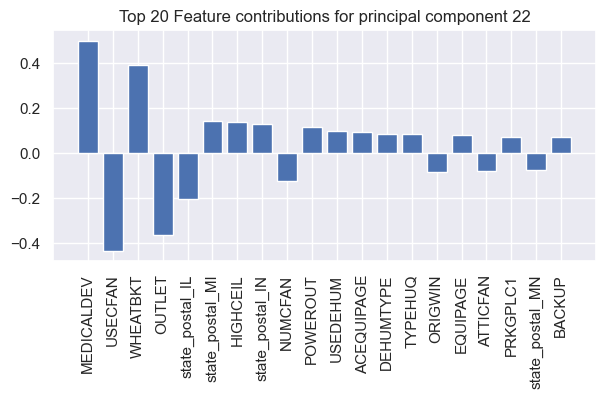

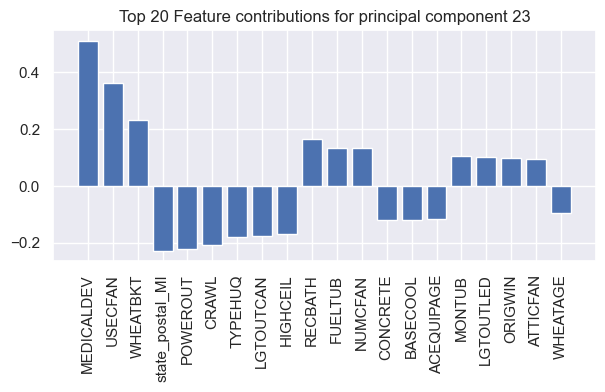

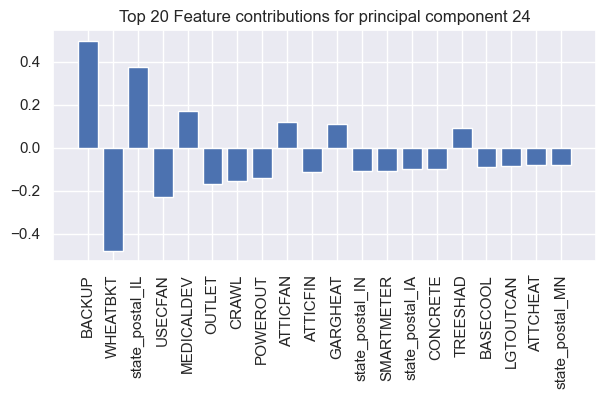

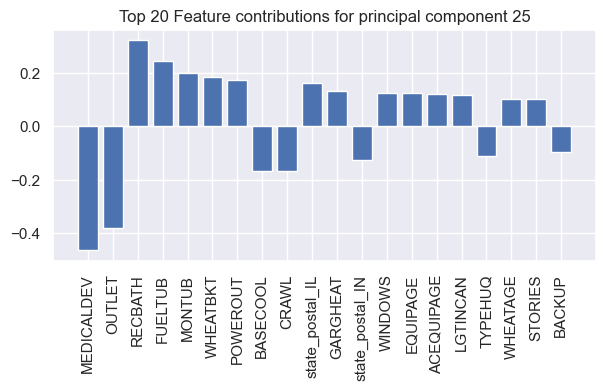

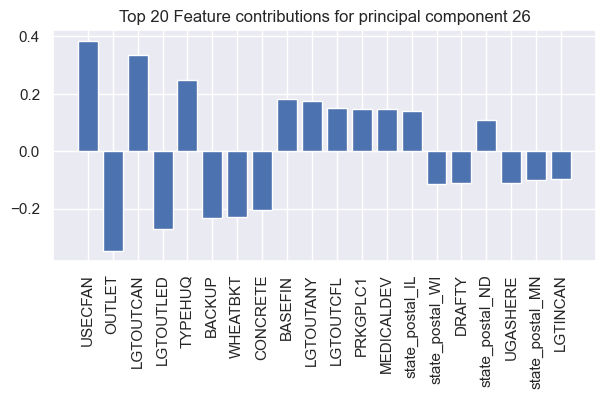

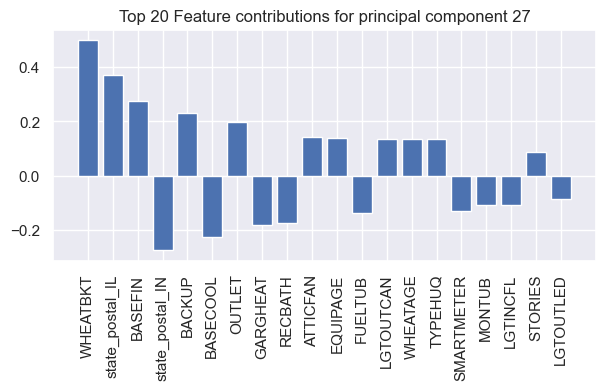

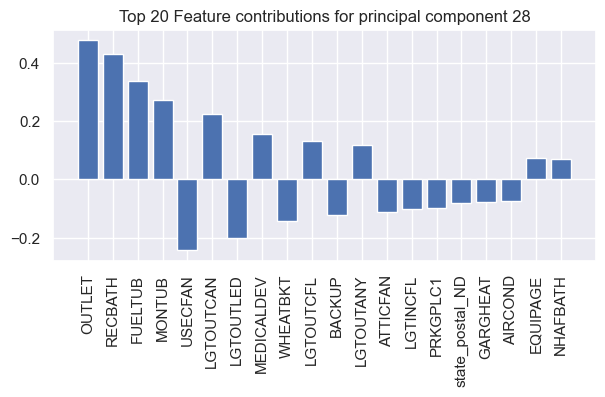

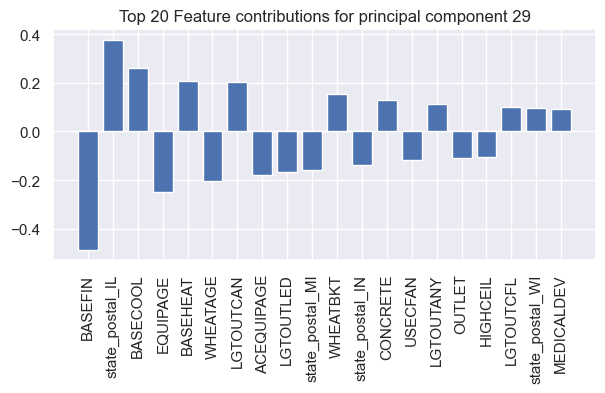

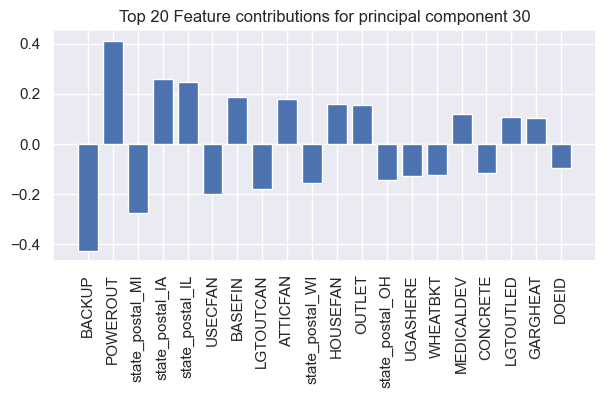

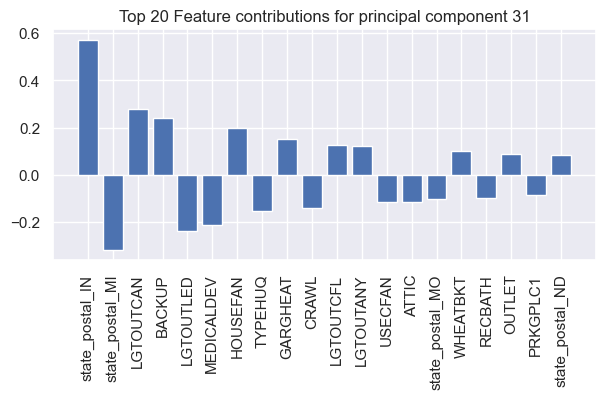

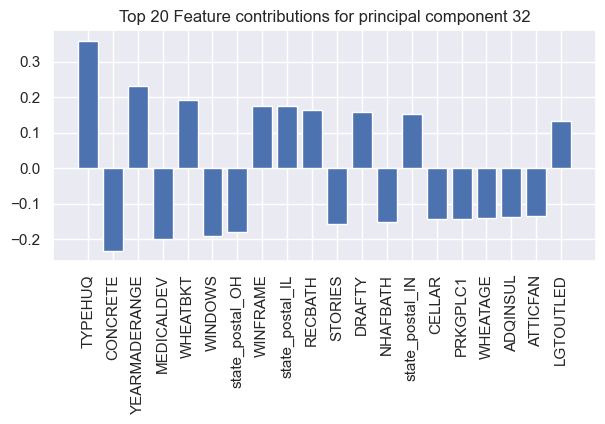

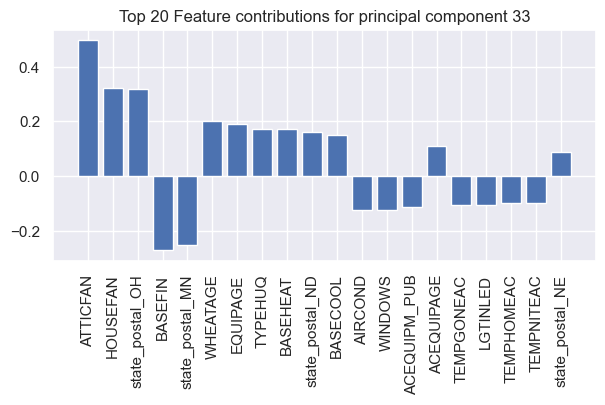

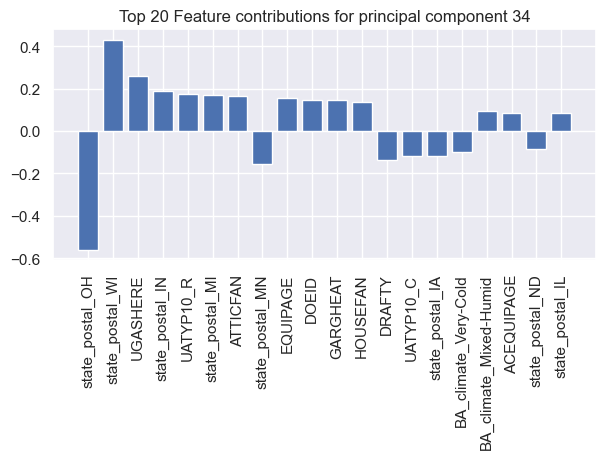

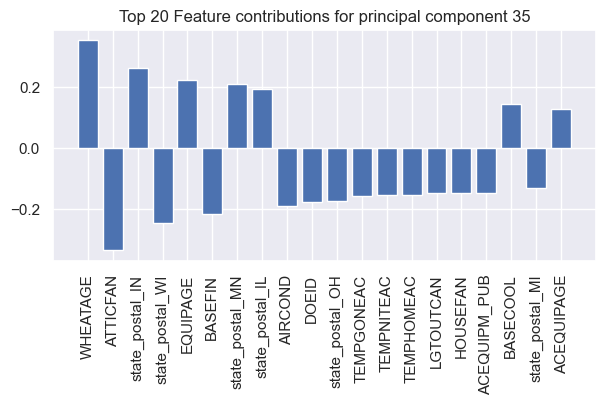

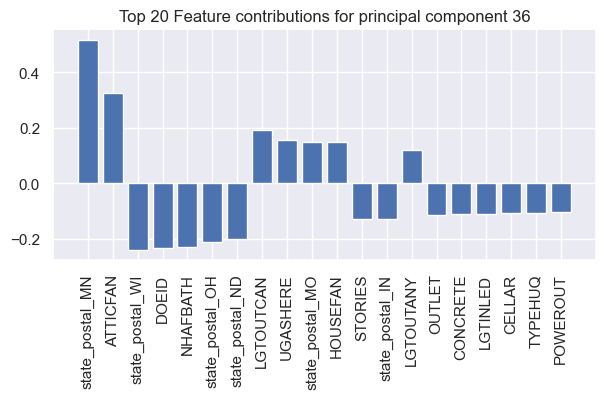

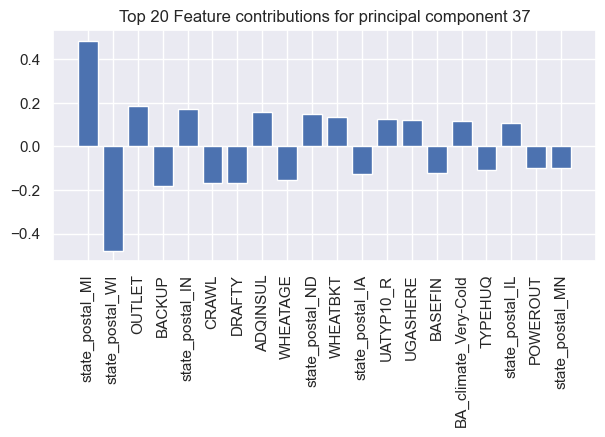

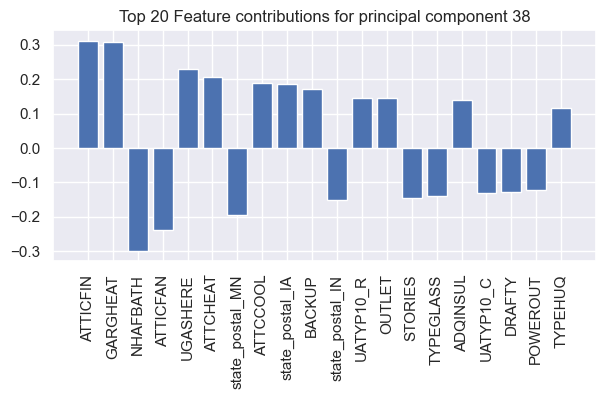

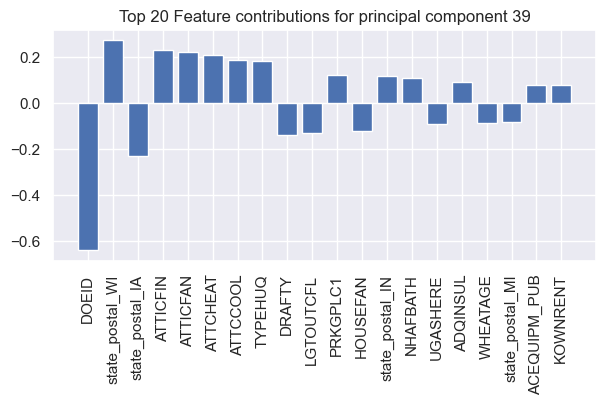

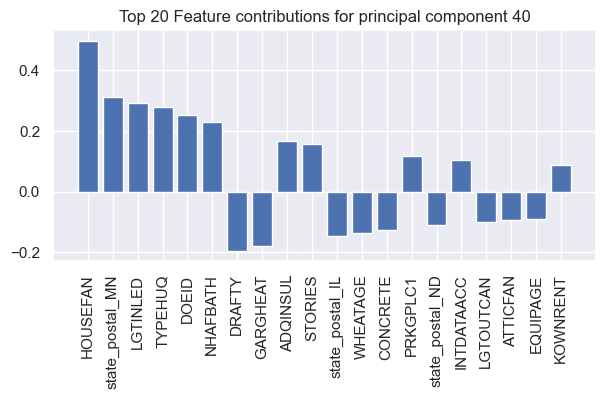

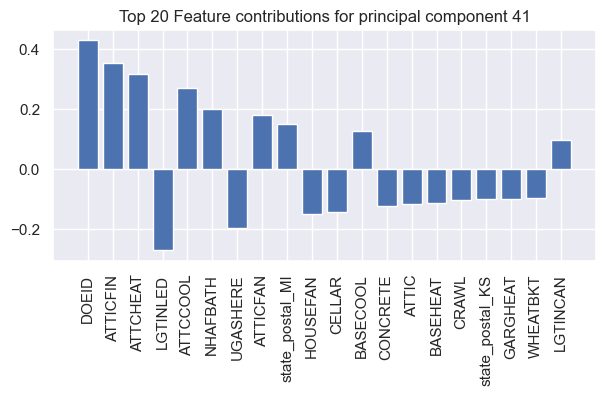

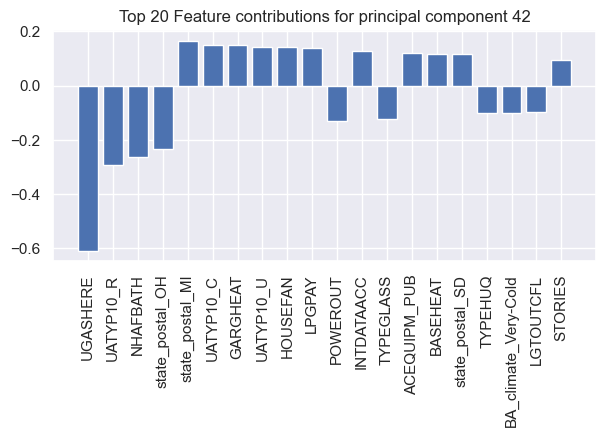

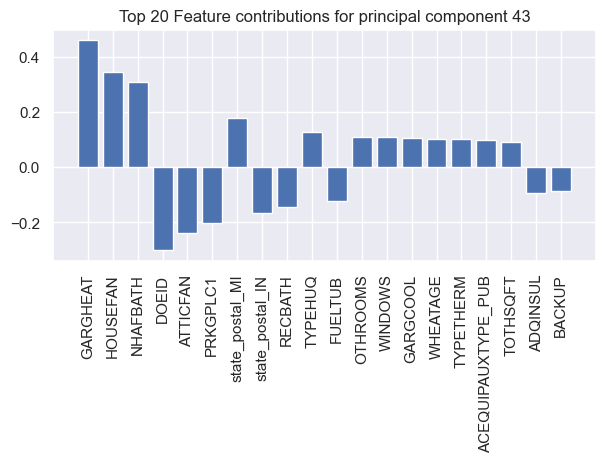

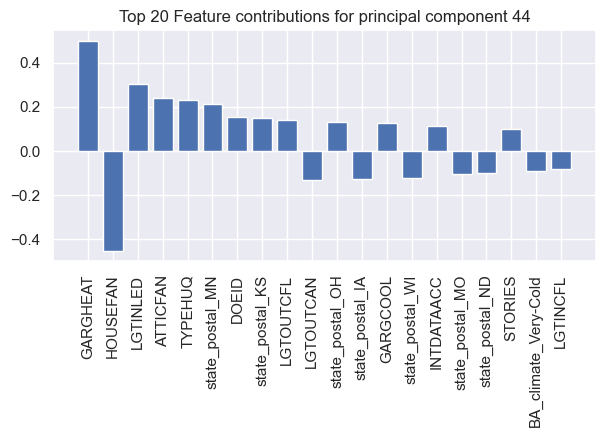

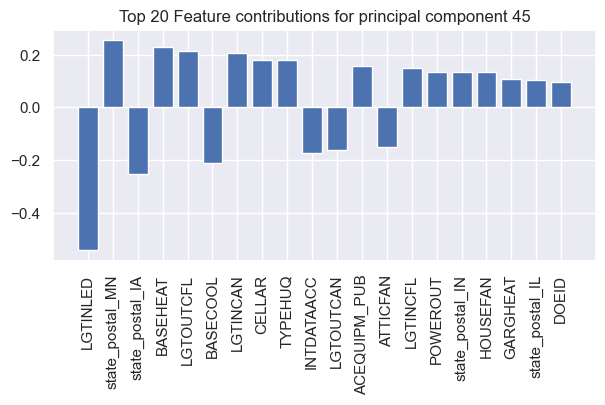

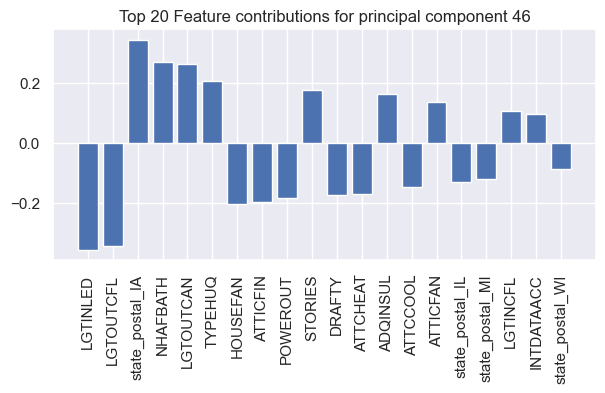

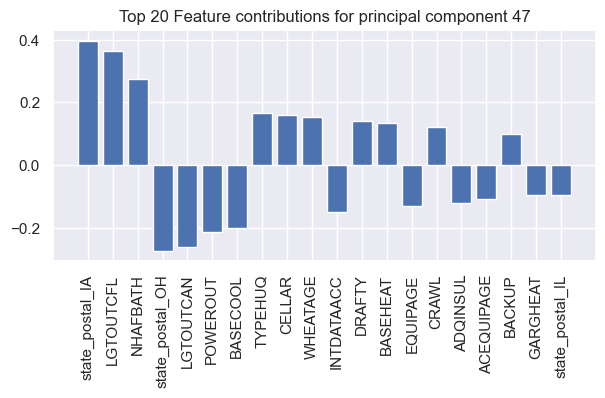

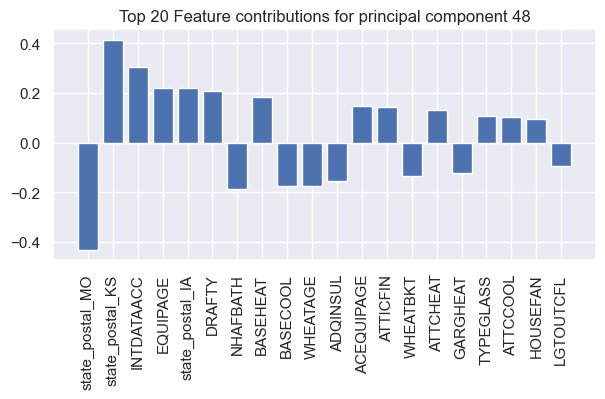

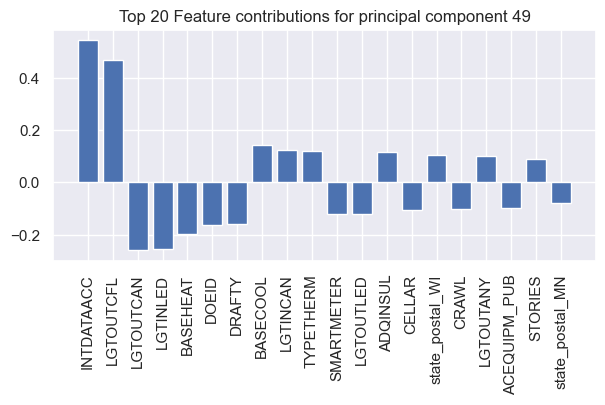

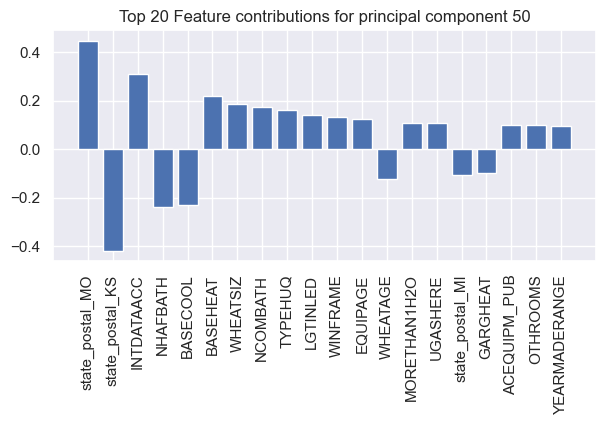

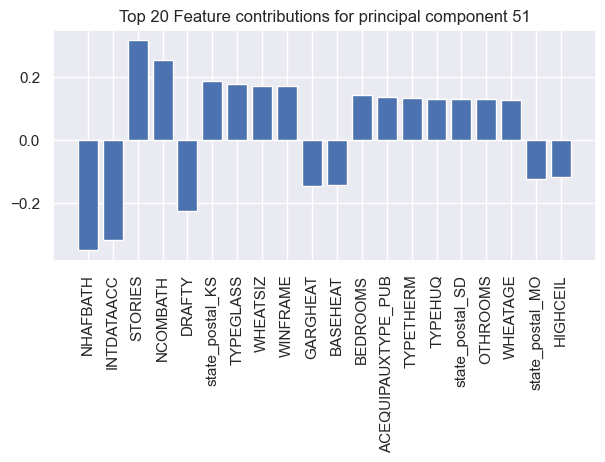

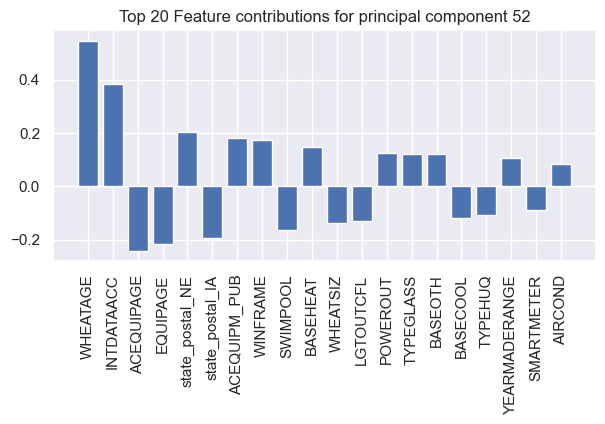

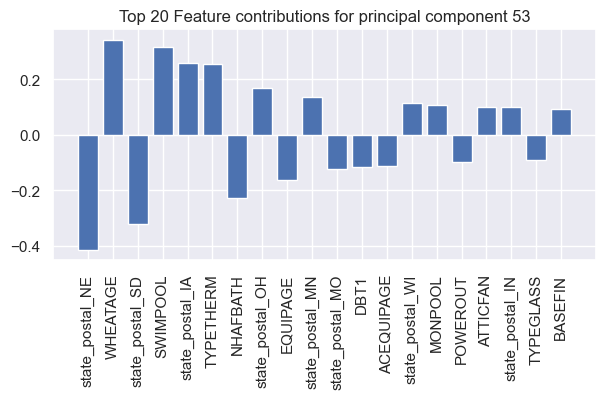

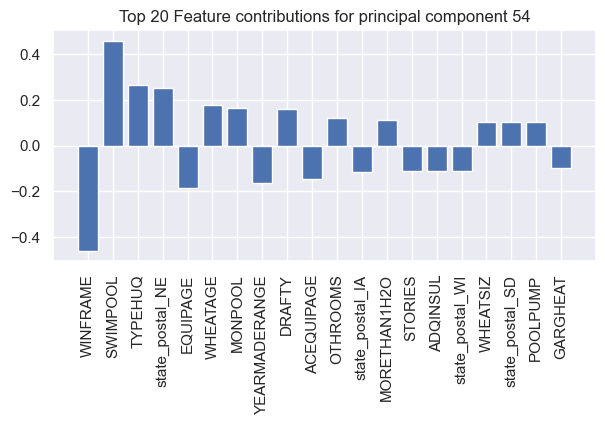

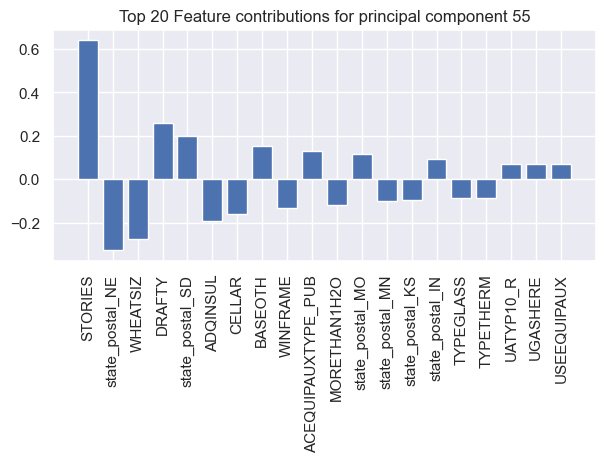

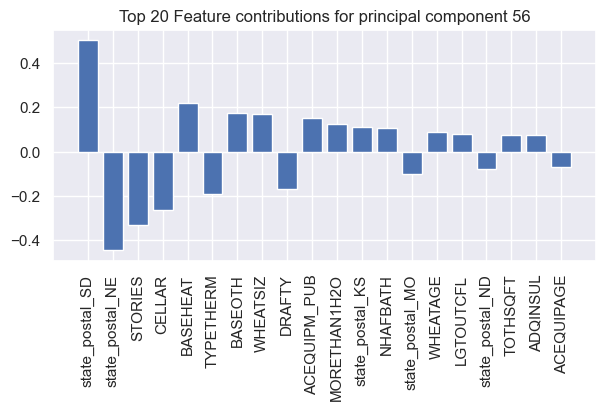

In [96]:
feature_names = subset_df.columns
top_features_list = []

for i, component in enumerate(pca.components_):
    # Getting the top 20 features for each component
    sorted_idx = np.argsort(np.abs(component))[-20:][::-1]
    top_features = np.array(feature_names)[sorted_idx]
    top_features_list.extend(top_features)
    top_components = component[sorted_idx]

    # Visualize the top 20 features for this component
    plt.figure(figsize=(7, 3))
    plt.bar(range(20), top_components)
    plt.title(f'Top 20 Feature contributions for principal component {i+1}')
    plt.xticks(range(20), top_features, rotation=90)
    plt.show()

# Get a list of unique top features across all components
top_features_list = list(set(top_features_list))